In [1]:
import datetime
import os.path as osp
import platform
import pickle as pkl

import matplotlib
import mplhep
import numpy as np
import torch
import torch_geometric
from pyg_ssl.args import parse_args
from pyg_ssl.mlpf import MLPF
from pyg_ssl.training_mlpf import training_loop_mlpf
from pyg_ssl.training_VICReg import training_loop_VICReg
from pyg_ssl.utils import CLUSTERS_X, TRACKS_X, data_split, load_VICReg, save_MLPF, save_VICReg, distinguish_PFelements, combine_PFelements
from pyg_ssl.VICReg import DECODER, ENCODER, VICReg

matplotlib.use("Agg")
mplhep.style.use(mplhep.styles.CMS)

# Ignore divide by 0 errors
np.seterr(divide="ignore", invalid="ignore")

# define the global base device
if torch.cuda.device_count():
    device = torch.device("cuda:0")
    print(f"Will use {torch.cuda.get_device_name(device)}")
else:
    device = "cpu"
    print("Will use cpu")
    
### useful object
class objectview(object):
    """converts a dict into an object"""

    def __init__(self, d):
        self.__dict__ = d    

Will use NVIDIA GeForce GTX 1080 Ti


In [66]:
### MLPF training loop

import json
import math
import pickle as pkl
import time
from typing import Optional

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import Tensor, nn
from torch.nn import functional as F

matplotlib.use("Agg")

# Ignore divide by 0 errors
np.seterr(divide="ignore", invalid="ignore")

# keep track of the training step across epochs
istep_global = 0


# from https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
class FocalLoss(nn.Module):
    def __init__(
        self, alpha: Optional[Tensor] = None, gamma: float = 0.0, reduction: str = "mean", ignore_index: int = -100
    ):
        if reduction not in ("mean", "sum", "none"):
            raise ValueError('Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction="none", ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ["alpha", "gamma", "ignore_index", "reduction"]
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f"{k}={v!r}" for k, v in zip(arg_keys, arg_vals)]
        arg_str = ", ".join(arg_strs)
        return f"{type(self).__name__}({arg_str})"

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.0)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt) ** self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss


def compute_weights(device, target_ids, num_classes):
    vs, cs = torch.unique(target_ids, return_counts=True)
    weights = torch.zeros(num_classes).to(device=device)
    for k, v in zip(vs, cs):
        weights[k] = 1.0 / math.sqrt(float(v))
    # weights[2] = weights[2] * 3  # emphasize nhadrons
    return weights


@torch.no_grad()
def validation_run(device, mlpf, train_loader, valid_loader, ssl_encoder):
    with torch.no_grad():
        optimizer = None
        ret = train(device, mlpf, train_loader, valid_loader, optimizer, ssl_encoder)
    return ret


def train(device, mlpf, train_loader, valid_loader, optimizer, ssl_encoder=None):
    """
    A training/validation run over a given epoch that gets called in the training_loop() function.
    When optimizer is set to None, it freezes the model for a validation_run.
    """

    is_train = not (optimizer is None)
    global istep_global

    loss_obj_id = FocalLoss(gamma=2.0)

    if is_train:
        print("---->Initiating a training run")
        mlpf.train()
        loader = train_loader
    else:
        print("---->Initiating a validation run")
        mlpf.eval()
        loader = valid_loader

    # initialize loss counters
    losses_of_interest = ["Total", "Classification", "Regression", "Charge"]
    losses = {}
    for loss in losses_of_interest:
        losses[loss] = 0.0

    for i, batch in tqdm.tqdm(enumerate(loader), total=len(loader)):

        if ssl_encoder is not None:
            # seperate PF-elements
            tracks, clusters = distinguish_PFelements(batch.to(device))

            # ENCODE
            embedding_tracks, embedding_clusters = ssl_encoder(tracks, clusters)

            # concat the inputs with embeddings
            tracks.x = torch.cat([batch.x[batch.x[:, 0] == 1], embedding_tracks], axis=1)
            clusters.x = torch.cat([batch.x[batch.x[:, 0] == 2], embedding_clusters], axis=1)

            # combine PF-elements
            event = combine_PFelements(tracks, clusters)

        else:
            event = batch.to(device)

        # make mlpf forward pass
        event_on_device = event.to(device)
        pred_ids_one_hot, pred_momentum, pred_charge = mlpf(event_on_device)
        target_ids = event_on_device.ygen_id

        target_momentum = event_on_device.ygen[:, 1:].to(dtype=torch.float32)
        target_charge = (event_on_device.ygen[:, 0] + 1).to(dtype=torch.float32)  # -1, 0, 1

        loss_ = {}
        # for CLASSIFYING PID
        loss_["Classification"] = 100 * loss_obj_id(pred_ids_one_hot, target_ids)
        # REGRESSING p4: mask the loss in cases there is no true particle
        msk_true_particle = torch.unsqueeze((target_ids != 0).to(dtype=torch.float32), axis=-1)
        loss_["Regression"] = 10 * torch.nn.functional.huber_loss(
            pred_momentum * msk_true_particle, target_momentum * msk_true_particle
        )
        # PREDICTING CHARGE
        loss_["Charge"] = torch.nn.functional.cross_entropy(
            pred_charge * msk_true_particle, (target_charge * msk_true_particle[:, 0]).to(dtype=torch.int64)
        )
        # TOTAL LOSS
        loss_["Total"] = loss_["Classification"] + loss_["Regression"] + loss_["Charge"]


        # update parameters
        if is_train:
            for param in mlpf.parameters():
                param.grad = None
            loss_["Total"].backward()
            optimizer.step()

        for loss in losses_of_interest:
            losses[loss] += loss_[loss].detach()

        # if i == 2:
        #     break

    for loss in losses_of_interest:
        losses[loss] = losses[loss].cpu().item() / (len(loader))

    print(
        "loss_id={:.2f} loss_momentum={:.2f} loss_charge={:.2f}".format(
            losses["Classification"], losses["Regression"], losses["Charge"]
        )
    )

    return losses


def training_loop_mlpf(device, mlpf, train_loader, valid_loader, n_epochs, patience, lr, ssl_encoder=None):
    """
    Main function to perform training. Will call the train() and validation_run() functions every epoch.

    Args:
        mlpf: the mlpf downstream task.
        train_loader: a pytorch Dataloader for training.
        valid_loader: a pytorch Dataloader for validation.
        patience: number of stale epochs allowed before stopping the training.
        lr: lr to use for training.
        mode: can be either `ssl` or `native`.
        ssl_encoder: the encoder part of VICReg. If None is provided then the function will run a supervised training.
    """

    t0_initial = time.time()

    losses_of_interest = ["Total", "Classification", "Regression"]

    losses = {}
    losses["train"], losses["valid"], best_val_loss, best_train_loss = {}, {}, {}, {}
    for loss in losses_of_interest:
        losses["train"][loss], losses["valid"][loss] = [], []
        best_val_loss[loss] = 99999.9

    stale_epochs = 0

    optimizer = torch.optim.AdamW(mlpf.parameters(), lr=lr)

    if ssl_encoder is not None:
        mode = "ssl"
        ssl_encoder.eval()
    else:
        mode = "native"
    print(f"Will launch a {mode} training of MLPF.")

    for epoch in range(n_epochs):
        t0 = time.time()

        if stale_epochs > patience:
            print("breaking due to stale epochs")
            break

        # training step
        losses_t = train(device, mlpf, train_loader, valid_loader, optimizer, ssl_encoder)
        for loss in losses_of_interest:
            losses["train"][loss].append(losses_t[loss])

        # validation step
        losses_v = validation_run(device, mlpf, train_loader, valid_loader, ssl_encoder)
        for loss in losses_of_interest:
            losses["valid"][loss].append(losses_v[loss])


        # save the lowest value of each component of the loss to print it on the legend of the loss plots
        for loss in losses_of_interest:
            if loss == "Total":
                if losses_v[loss] < best_val_loss[loss]:
                    best_val_loss[loss] = losses_v[loss]
                    best_train_loss[loss] = losses_t[loss]

                    # for early-stopping purposes
                    stale_epochs = 0
                else:
                    stale_epochs += 1
            else:
                if losses_v[loss] < best_val_loss[loss]:
                    best_val_loss[loss] = losses_v[loss]
                    best_train_loss[loss] = losses_t[loss]

        t1 = time.time()

        epochs_remaining = n_epochs - (epoch + 1)
        time_per_epoch = (t1 - t0_initial) / (epoch + 1)
        eta = epochs_remaining * time_per_epoch / 60

        print(
            f"epoch={epoch + 1} / {n_epochs} "
            + f"train_loss={round(losses_t['Total'], 4)} "
            + f"valid_loss={round(losses_v['Total'], 4)} "
            + f"stale={stale_epochs} "
            + f"time={round((t1-t0)/60, 2)}m "
            + f"eta={round(eta, 1)}m"
        )


        print("----------------------------------------------------------")
    print(f"Done with training. Total training time is {round((time.time() - t0_initial)/60,3)}min")
    print("----------------------------------------------------------")
    print("----------------------------------------------------------")
    print("----------------------------------------------------------")
    return losses, best_val_loss

In [59]:
## to load a VICReg model
def load_(vicreg_model):
    outpath = f"/pfclicvol/experiments/{vicreg_model}"
    state_dict = torch.load(f"{outpath}/VICReg_best_epoch_weights.pth")

    with open(f"{outpath}/encoder_model_kwargs.pkl", "rb") as f:
        encoder_model_kwargs = pkl.load(f)
    with open(f"{outpath}/decoder_model_kwargs.pkl", "rb") as f:
        decoder_model_kwargs = pkl.load(f)

    vicreg_encoder = ENCODER(**encoder_model_kwargs).to(device)
    vicreg_decoder = DECODER(**decoder_model_kwargs).to(device)

    vicreg = VICReg(vicreg_encoder, vicreg_decoder)

    ### because model was saved using dataparallel
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove module.
        new_state_dict[name] = v
        # print('name is:', name)
    state_dict=new_state_dict

    vicreg.load_state_dict(state_dict)

    return vicreg_encoder

# Load dataset

In [79]:
# load the clic dataset
data_VICReg_train, data_VICReg_valid, data_mlpf_train, data_mlpf_valid, data_test_qcd, data_test_ttbar = data_split(
    "/pfclicvol/data/clic_edm4hep", "quick"
)

Will use data split mode `quick`
Will use 25843 events to train VICReg
Will use 2871 events to validate VICReg
Will use 6461 events to train MLPF
Will use 718 events to validate MLPF


In [86]:
bs_mlpf = 300

print("------> Progressing to MLPF trainings...")
print(f"Will use {len(data_mlpf_train)} events for train")
print(f"Will use {len(data_mlpf_valid)} events for valid")

train_loader = torch_geometric.loader.DataLoader(data_mlpf_train, bs_mlpf)
valid_loader = torch_geometric.loader.DataLoader(data_mlpf_valid, bs_mlpf)

input_ = max(CLUSTERS_X, TRACKS_X) + 1  # max cz we pad when we concatenate them & +1 cz there's the `type` feature

------> Progressing to MLPF trainings...
Will use 6461 events for train
Will use 718 events for valid


# Perform MLPF training

In [84]:
mlpf_ssl = {
    "input_dim": input_,
    "embedding_dim": 256,
    "width": 256,
    "k": 32,
    "num_convs": 0,
    "dropout": 0.4,
    "ssl": True,
    "VICReg_embedding_dim": 256,
}

mlpf_native = {
    "input_dim": input_,
    "embedding_dim": 256,
    "width": 256,
    "k": 32,
    "num_convs": 0,
    "dropout": 0.4,
    "ssl": False,
}

In [ ]:
### start with these

losses_ALL = {}
best_val_loss = {}

vicreg_models = ["native", "VICReg_2_1", "VICReg_6_1"]
for vicreg_model in vicreg_models:
    print(f"Will use {vicreg_model}")

    if vicreg_model == "native":
        mlpf = MLPF(**mlpf_native).to(device)
        vicreg_encoder = None
    else:
        mlpf = MLPF(**mlpf_ssl).to(device)
        vicreg_encoder = load_(vicreg_model)
                
    losses_ALL[vicreg_model], best_val_loss[vicreg_model] = training_loop_mlpf(
                    device,
                    mlpf,
                    train_loader,
                    valid_loader,
                    300,
                    50,
                    5e-5,
                    vicreg_encoder,
                )

Will use native
Will launch a native training of MLPF.
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.44it/s]


loss_id=101.25 loss_momentum=2.34 loss_charge=0.98
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.86it/s]


loss_id=63.85 loss_momentum=1.83 loss_charge=0.70
epoch=1 / 300 train_loss=104.5689 valid_loss=66.3814 stale=0 time=0.06m eta=18.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.60it/s]


loss_id=65.78 loss_momentum=1.99 loss_charge=0.77
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.50it/s]


loss_id=41.02 loss_momentum=1.81 loss_charge=0.64
epoch=2 / 300 train_loss=68.5518 valid_loss=43.4751 stale=0 time=0.06m eta=17.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.42it/s]


loss_id=48.32 loss_momentum=1.89 loss_charge=0.68
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.69it/s]


loss_id=42.09 loss_momentum=1.80 loss_charge=0.64
epoch=3 / 300 train_loss=50.8918 valid_loss=44.5295 stale=1 time=0.06m eta=17.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.17it/s]


loss_id=40.89 loss_momentum=1.85 loss_charge=0.66
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.36it/s]


loss_id=38.65 loss_momentum=1.79 loss_charge=0.64
epoch=4 / 300 train_loss=43.4006 valid_loss=41.0888 stale=0 time=0.06m eta=17.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.62it/s]


loss_id=37.24 loss_momentum=1.83 loss_charge=0.65
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.05it/s]


loss_id=34.99 loss_momentum=1.79 loss_charge=0.64
epoch=5 / 300 train_loss=39.7199 valid_loss=37.4167 stale=0 time=0.06m eta=17.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.45it/s]


loss_id=35.01 loss_momentum=1.82 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.54it/s]


loss_id=33.17 loss_momentum=1.79 loss_charge=0.64
epoch=6 / 300 train_loss=37.4654 valid_loss=35.5954 stale=0 time=0.06m eta=17.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.24it/s]


loss_id=33.64 loss_momentum=1.81 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.34it/s]


loss_id=32.04 loss_momentum=1.79 loss_charge=0.64
epoch=7 / 300 train_loss=36.093 valid_loss=34.4603 stale=0 time=0.06m eta=17.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.75it/s]


loss_id=32.70 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.52it/s]


loss_id=31.13 loss_momentum=1.78 loss_charge=0.64
epoch=8 / 300 train_loss=35.1434 valid_loss=33.5513 stale=0 time=0.06m eta=17.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.52it/s]


loss_id=31.94 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.73it/s]


loss_id=30.51 loss_momentum=1.78 loss_charge=0.64
epoch=9 / 300 train_loss=34.3757 valid_loss=32.9297 stale=0 time=0.06m eta=17.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.28it/s]


loss_id=31.37 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.35it/s]


loss_id=30.00 loss_momentum=1.78 loss_charge=0.64
epoch=10 / 300 train_loss=33.7985 valid_loss=32.4184 stale=0 time=0.06m eta=17.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.26it/s]


loss_id=30.90 loss_momentum=1.79 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.57it/s]


loss_id=29.63 loss_momentum=1.78 loss_charge=0.64
epoch=11 / 300 train_loss=33.3256 valid_loss=32.0467 stale=0 time=0.06m eta=17.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.49it/s]


loss_id=30.56 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.32it/s]


loss_id=29.33 loss_momentum=1.77 loss_charge=0.64
epoch=12 / 300 train_loss=32.9817 valid_loss=31.739 stale=0 time=0.06m eta=17.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.52it/s]


loss_id=30.26 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.99it/s]


loss_id=29.11 loss_momentum=1.77 loss_charge=0.64
epoch=13 / 300 train_loss=32.6868 valid_loss=31.5204 stale=0 time=0.06m eta=17.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.45it/s]


loss_id=29.91 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.13it/s]


loss_id=28.93 loss_momentum=1.76 loss_charge=0.64
epoch=14 / 300 train_loss=32.3333 valid_loss=31.331 stale=0 time=0.06m eta=17.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.49it/s]


loss_id=29.72 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.18it/s]


loss_id=28.82 loss_momentum=1.76 loss_charge=0.64
epoch=15 / 300 train_loss=32.1366 valid_loss=31.2136 stale=0 time=0.06m eta=17.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.98it/s]


loss_id=29.48 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.00it/s]


loss_id=28.71 loss_momentum=1.76 loss_charge=0.64
epoch=16 / 300 train_loss=31.8937 valid_loss=31.1011 stale=0 time=0.06m eta=17.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.38it/s]


loss_id=29.34 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.17it/s]


loss_id=28.62 loss_momentum=1.75 loss_charge=0.64
epoch=17 / 300 train_loss=31.752 valid_loss=31.007 stale=0 time=0.06m eta=17.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.33it/s]


loss_id=29.15 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.41it/s]


loss_id=28.53 loss_momentum=1.75 loss_charge=0.64
epoch=18 / 300 train_loss=31.5558 valid_loss=30.9129 stale=0 time=0.06m eta=17.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.58it/s]


loss_id=29.09 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.34it/s]


loss_id=28.46 loss_momentum=1.75 loss_charge=0.64
epoch=19 / 300 train_loss=31.4981 valid_loss=30.8392 stale=0 time=0.06m eta=17.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.49it/s]


loss_id=28.90 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.99it/s]


loss_id=28.40 loss_momentum=1.74 loss_charge=0.64
epoch=20 / 300 train_loss=31.3065 valid_loss=30.7771 stale=0 time=0.06m eta=16.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.25it/s]


loss_id=28.81 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.70it/s]


loss_id=28.36 loss_momentum=1.74 loss_charge=0.64
epoch=21 / 300 train_loss=31.2122 valid_loss=30.7315 stale=0 time=0.06m eta=16.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.12it/s]


loss_id=28.70 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.27it/s]


loss_id=28.26 loss_momentum=1.73 loss_charge=0.64
epoch=22 / 300 train_loss=31.0975 valid_loss=30.633 stale=0 time=0.06m eta=16.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.53it/s]


loss_id=28.62 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.32it/s]


loss_id=28.21 loss_momentum=1.73 loss_charge=0.64
epoch=23 / 300 train_loss=31.0104 valid_loss=30.5755 stale=0 time=0.06m eta=16.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.58it/s]


loss_id=28.53 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.34it/s]


loss_id=28.16 loss_momentum=1.72 loss_charge=0.64
epoch=24 / 300 train_loss=30.9237 valid_loss=30.522 stale=0 time=0.06m eta=16.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.52it/s]


loss_id=28.45 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.58it/s]


loss_id=28.12 loss_momentum=1.72 loss_charge=0.64
epoch=25 / 300 train_loss=30.8314 valid_loss=30.4786 stale=0 time=0.06m eta=16.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.12it/s]


loss_id=28.39 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.28it/s]


loss_id=28.05 loss_momentum=1.71 loss_charge=0.64
epoch=26 / 300 train_loss=30.7725 valid_loss=30.4018 stale=0 time=0.06m eta=16.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.57it/s]


loss_id=28.30 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.79it/s]


loss_id=28.01 loss_momentum=1.71 loss_charge=0.64
epoch=27 / 300 train_loss=30.6725 valid_loss=30.3576 stale=0 time=0.06m eta=16.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.35it/s]


loss_id=28.22 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.70it/s]


loss_id=27.95 loss_momentum=1.70 loss_charge=0.64
epoch=28 / 300 train_loss=30.5925 valid_loss=30.285 stale=0 time=0.06m eta=16.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.17it/s]


loss_id=28.21 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.63it/s]


loss_id=27.92 loss_momentum=1.70 loss_charge=0.64
epoch=29 / 300 train_loss=30.5736 valid_loss=30.2517 stale=0 time=0.06m eta=16.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.48it/s]


loss_id=28.10 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.41it/s]


loss_id=27.84 loss_momentum=1.69 loss_charge=0.64
epoch=30 / 300 train_loss=30.4668 valid_loss=30.1723 stale=0 time=0.06m eta=16.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.20it/s]


loss_id=28.05 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.32it/s]


loss_id=27.77 loss_momentum=1.69 loss_charge=0.64
epoch=31 / 300 train_loss=30.411 valid_loss=30.0891 stale=0 time=0.06m eta=16.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.66it/s]


loss_id=28.04 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.26it/s]


loss_id=27.71 loss_momentum=1.68 loss_charge=0.64
epoch=32 / 300 train_loss=30.3939 valid_loss=30.0292 stale=0 time=0.06m eta=16.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.32it/s]


loss_id=27.93 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.26it/s]


loss_id=27.67 loss_momentum=1.68 loss_charge=0.64
epoch=33 / 300 train_loss=30.28 valid_loss=29.9842 stale=0 time=0.06m eta=16.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.41it/s]


loss_id=27.89 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.47it/s]


loss_id=27.61 loss_momentum=1.67 loss_charge=0.64
epoch=34 / 300 train_loss=30.2393 valid_loss=29.9213 stale=0 time=0.06m eta=16.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.48it/s]


loss_id=27.86 loss_momentum=1.71 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.91it/s]


loss_id=27.55 loss_momentum=1.67 loss_charge=0.64
epoch=35 / 300 train_loss=30.1989 valid_loss=29.8523 stale=0 time=0.06m eta=16.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.61it/s]


loss_id=27.79 loss_momentum=1.71 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.39it/s]


loss_id=27.52 loss_momentum=1.66 loss_charge=0.64
epoch=36 / 300 train_loss=30.1307 valid_loss=29.8181 stale=0 time=0.06m eta=16.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.30it/s]


loss_id=27.77 loss_momentum=1.70 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.24it/s]


loss_id=27.44 loss_momentum=1.66 loss_charge=0.64
epoch=37 / 300 train_loss=30.0988 valid_loss=29.7336 stale=0 time=0.06m eta=15.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.62it/s]


loss_id=27.72 loss_momentum=1.70 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.81it/s]


loss_id=27.38 loss_momentum=1.65 loss_charge=0.64
epoch=38 / 300 train_loss=30.0438 valid_loss=29.6629 stale=0 time=0.06m eta=15.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.63it/s]


loss_id=27.69 loss_momentum=1.69 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.75it/s]


loss_id=27.33 loss_momentum=1.65 loss_charge=0.64
epoch=39 / 300 train_loss=30.0165 valid_loss=29.6136 stale=0 time=0.06m eta=15.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.15it/s]


loss_id=27.62 loss_momentum=1.69 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.09it/s]


loss_id=27.30 loss_momentum=1.64 loss_charge=0.64
epoch=40 / 300 train_loss=29.9463 valid_loss=29.5739 stale=0 time=0.06m eta=15.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.66it/s]


loss_id=27.58 loss_momentum=1.69 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.77it/s]


loss_id=27.22 loss_momentum=1.64 loss_charge=0.64
epoch=41 / 300 train_loss=29.8971 valid_loss=29.4911 stale=0 time=0.06m eta=15.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.66it/s]


loss_id=27.56 loss_momentum=1.68 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.53it/s]


loss_id=27.17 loss_momentum=1.63 loss_charge=0.64
epoch=42 / 300 train_loss=29.8687 valid_loss=29.4384 stale=0 time=0.06m eta=15.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.66it/s]


loss_id=27.51 loss_momentum=1.68 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.13it/s]


loss_id=27.10 loss_momentum=1.63 loss_charge=0.64
epoch=43 / 300 train_loss=29.8139 valid_loss=29.3655 stale=0 time=0.06m eta=15.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.60it/s]


loss_id=27.44 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.64it/s]


loss_id=27.05 loss_momentum=1.63 loss_charge=0.64
epoch=44 / 300 train_loss=29.7425 valid_loss=29.3083 stale=0 time=0.06m eta=15.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.65it/s]


loss_id=27.42 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.46it/s]


loss_id=26.97 loss_momentum=1.62 loss_charge=0.64
epoch=45 / 300 train_loss=29.7225 valid_loss=29.2281 stale=0 time=0.06m eta=15.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.66it/s]


loss_id=27.39 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.95it/s]


loss_id=26.91 loss_momentum=1.62 loss_charge=0.64
epoch=46 / 300 train_loss=29.692 valid_loss=29.1628 stale=0 time=0.06m eta=15.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.69it/s]


loss_id=27.34 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.19it/s]


loss_id=26.82 loss_momentum=1.62 loss_charge=0.64
epoch=47 / 300 train_loss=29.6327 valid_loss=29.0782 stale=0 time=0.06m eta=15.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.86it/s]


loss_id=27.27 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.75it/s]


loss_id=26.78 loss_momentum=1.62 loss_charge=0.64
epoch=48 / 300 train_loss=29.5649 valid_loss=29.0346 stale=0 time=0.06m eta=15.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.58it/s]


loss_id=27.25 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.22it/s]


loss_id=26.72 loss_momentum=1.61 loss_charge=0.64
epoch=49 / 300 train_loss=29.5361 valid_loss=28.9649 stale=0 time=0.06m eta=15.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.64it/s]


loss_id=27.22 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.97it/s]


loss_id=26.67 loss_momentum=1.61 loss_charge=0.64
epoch=50 / 300 train_loss=29.5067 valid_loss=28.9171 stale=0 time=0.06m eta=15.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.65it/s]


loss_id=27.15 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.20it/s]


loss_id=26.58 loss_momentum=1.61 loss_charge=0.64
epoch=51 / 300 train_loss=29.4329 valid_loss=28.8245 stale=0 time=0.06m eta=14.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.42it/s]


loss_id=27.13 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.39it/s]


loss_id=26.51 loss_momentum=1.61 loss_charge=0.64
epoch=52 / 300 train_loss=29.4122 valid_loss=28.7511 stale=0 time=0.06m eta=14.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.14it/s]


loss_id=27.09 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.79it/s]


loss_id=26.44 loss_momentum=1.61 loss_charge=0.64
epoch=53 / 300 train_loss=29.3706 valid_loss=28.6848 stale=0 time=0.06m eta=14.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.33it/s]


loss_id=27.02 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.92it/s]


loss_id=26.36 loss_momentum=1.61 loss_charge=0.64
epoch=54 / 300 train_loss=29.2971 valid_loss=28.599 stale=0 time=0.06m eta=14.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.51it/s]


loss_id=26.98 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.72it/s]


loss_id=26.29 loss_momentum=1.61 loss_charge=0.64
epoch=55 / 300 train_loss=29.2534 valid_loss=28.5283 stale=0 time=0.06m eta=14.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.22it/s]


loss_id=26.93 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.60it/s]


loss_id=26.22 loss_momentum=1.60 loss_charge=0.64
epoch=56 / 300 train_loss=29.2014 valid_loss=28.4572 stale=0 time=0.06m eta=14.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.66it/s]


loss_id=26.90 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.91it/s]


loss_id=26.14 loss_momentum=1.60 loss_charge=0.64
epoch=57 / 300 train_loss=29.1719 valid_loss=28.3774 stale=0 time=0.06m eta=14.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.41it/s]


loss_id=26.87 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.64it/s]


loss_id=26.08 loss_momentum=1.60 loss_charge=0.64
epoch=58 / 300 train_loss=29.142 valid_loss=28.3182 stale=0 time=0.06m eta=14.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.12it/s]


loss_id=26.83 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.34it/s]


loss_id=26.00 loss_momentum=1.60 loss_charge=0.64
epoch=59 / 300 train_loss=29.1002 valid_loss=28.2324 stale=0 time=0.06m eta=14.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.48it/s]


loss_id=26.77 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.83it/s]


loss_id=25.92 loss_momentum=1.60 loss_charge=0.63
epoch=60 / 300 train_loss=29.0321 valid_loss=28.162 stale=0 time=0.06m eta=14.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.23it/s]


loss_id=26.73 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.13it/s]


loss_id=25.83 loss_momentum=1.60 loss_charge=0.64
epoch=61 / 300 train_loss=28.9967 valid_loss=28.0695 stale=0 time=0.06m eta=14.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.32it/s]


loss_id=26.67 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.23it/s]


loss_id=25.76 loss_momentum=1.60 loss_charge=0.63
epoch=62 / 300 train_loss=28.9372 valid_loss=27.9977 stale=0 time=0.06m eta=14.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.61it/s]


loss_id=26.64 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.05it/s]


loss_id=25.68 loss_momentum=1.60 loss_charge=0.63
epoch=63 / 300 train_loss=28.8994 valid_loss=27.9128 stale=0 time=0.06m eta=14.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.33it/s]


loss_id=26.60 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.33it/s]


loss_id=25.59 loss_momentum=1.60 loss_charge=0.63
epoch=64 / 300 train_loss=28.8591 valid_loss=27.8225 stale=0 time=0.06m eta=14.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.22it/s]


loss_id=26.54 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.55it/s]


loss_id=25.49 loss_momentum=1.60 loss_charge=0.63
epoch=65 / 300 train_loss=28.8005 valid_loss=27.7244 stale=0 time=0.06m eta=14.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.27it/s]


loss_id=26.50 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.65it/s]


loss_id=25.42 loss_momentum=1.60 loss_charge=0.63
epoch=66 / 300 train_loss=28.7594 valid_loss=27.6534 stale=0 time=0.06m eta=14.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.68it/s]


loss_id=26.46 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.19it/s]


loss_id=25.35 loss_momentum=1.60 loss_charge=0.63
epoch=67 / 300 train_loss=28.7155 valid_loss=27.5762 stale=0 time=0.06m eta=14.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.44it/s]


loss_id=26.40 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.96it/s]


loss_id=25.26 loss_momentum=1.60 loss_charge=0.63
epoch=68 / 300 train_loss=28.6569 valid_loss=27.4944 stale=0 time=0.06m eta=14.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.31it/s]


loss_id=26.37 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.48it/s]


loss_id=25.20 loss_momentum=1.59 loss_charge=0.63
epoch=69 / 300 train_loss=28.6203 valid_loss=27.4284 stale=0 time=0.06m eta=13.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.57it/s]


loss_id=26.31 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.51it/s]


loss_id=25.12 loss_momentum=1.59 loss_charge=0.63
epoch=70 / 300 train_loss=28.5674 valid_loss=27.3463 stale=0 time=0.06m eta=13.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.29it/s]


loss_id=26.27 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.22it/s]


loss_id=25.03 loss_momentum=1.59 loss_charge=0.63
epoch=71 / 300 train_loss=28.5255 valid_loss=27.258 stale=0 time=0.06m eta=13.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.28it/s]


loss_id=26.21 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.53it/s]


loss_id=24.94 loss_momentum=1.59 loss_charge=0.63
epoch=72 / 300 train_loss=28.461 valid_loss=27.1642 stale=0 time=0.06m eta=13.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.29it/s]


loss_id=26.17 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.68it/s]


loss_id=24.86 loss_momentum=1.59 loss_charge=0.63
epoch=73 / 300 train_loss=28.4175 valid_loss=27.0834 stale=0 time=0.06m eta=13.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.57it/s]


loss_id=26.14 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.14it/s]


loss_id=24.80 loss_momentum=1.59 loss_charge=0.63
epoch=74 / 300 train_loss=28.3912 valid_loss=27.0273 stale=0 time=0.06m eta=13.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.18it/s]


loss_id=26.06 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.61it/s]


loss_id=24.72 loss_momentum=1.59 loss_charge=0.63
epoch=75 / 300 train_loss=28.3103 valid_loss=26.949 stale=0 time=0.06m eta=13.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.27it/s]


loss_id=26.04 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.55it/s]


loss_id=24.65 loss_momentum=1.59 loss_charge=0.63
epoch=76 / 300 train_loss=28.2848 valid_loss=26.8726 stale=0 time=0.06m eta=13.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.61it/s]


loss_id=25.96 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.76it/s]


loss_id=24.56 loss_momentum=1.59 loss_charge=0.63
epoch=77 / 300 train_loss=28.2095 valid_loss=26.7851 stale=0 time=0.06m eta=13.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.66it/s]


loss_id=25.91 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.41it/s]


loss_id=24.49 loss_momentum=1.59 loss_charge=0.63
epoch=78 / 300 train_loss=28.1501 valid_loss=26.7167 stale=0 time=0.06m eta=13.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.48it/s]


loss_id=25.85 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.63it/s]


loss_id=24.41 loss_momentum=1.59 loss_charge=0.63
epoch=79 / 300 train_loss=28.0926 valid_loss=26.6361 stale=0 time=0.06m eta=13.3m
----------------------------------------------------------
---->Initiating a training run


 14%|█████████████▍                                                                                     | 3/22 [00:00<00:02,  6.87it/s]

In [ ]:
### anything you wanna add?

vicreg_models = ["VICReg_4_1", "VICReg_6_2", "VICReg_6_3", "VICReg_7_3"]
for vicreg_model in vicreg_models:
    print(f"Will use {vicreg_model}")

    if vicreg_model == "native":
        mlpf = MLPF(**mlpf_native).to(device)
        vicreg_encoder = None
    else:
        mlpf = MLPF(**mlpf_ssl).to(device)
        vicreg_encoder = load_(vicreg_model)
                
    losses_ALL[vicreg_model], best_val_loss[vicreg_model] = training_loop_mlpf(
                    device,
                    mlpf,
                    train_loader,
                    valid_loader,
                    4,
                    50,
                    5e-5,
                    vicreg_encoder,
                )

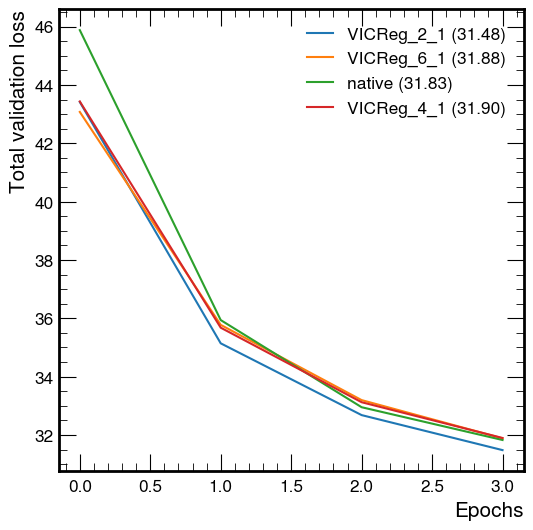

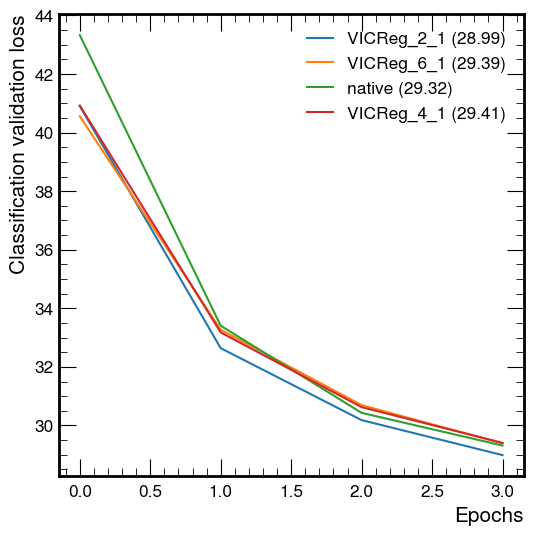

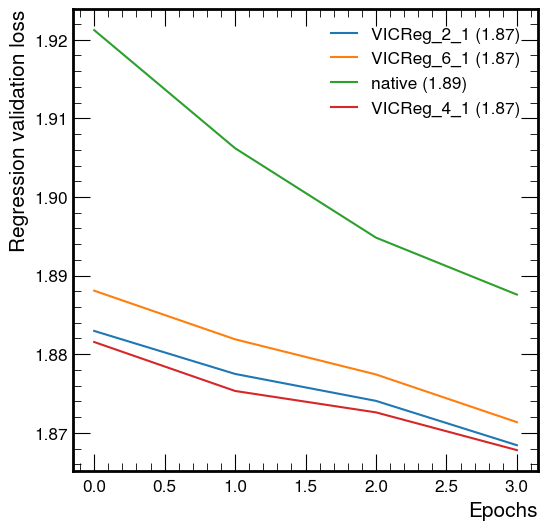

In [77]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})
                     
for loss in ["Total", "Classification", "Regression"]:
        # make total loss plot
        fig, ax = plt.subplots(figsize=(6,6))

        for vicreg_model in losses_ALL:
            ax.plot(range(len(losses_ALL[vicreg_model]["valid"][loss])), losses_ALL[vicreg_model]["valid"][loss], label=f"{vicreg_model} ({best_val_loss[vicreg_model][loss]:.2f})")

        ax.set_xlabel("Epochs")
        ax.set_ylabel(f"{loss} validation loss")
        ax.legend()

# OLD

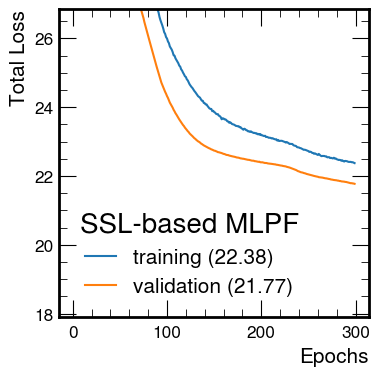

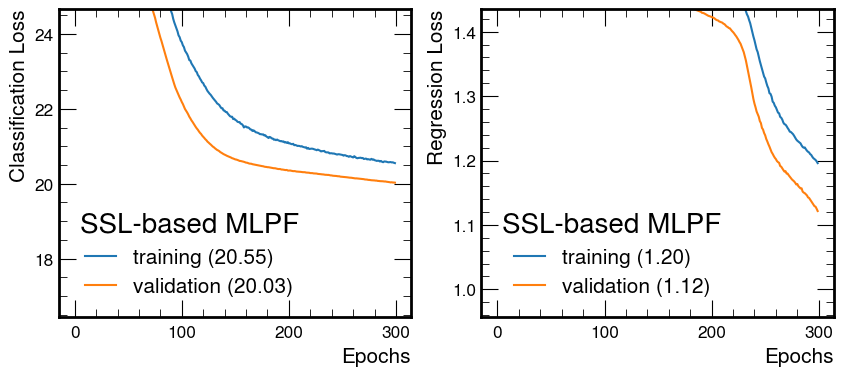

In [30]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(range(len(losses_train_tot)), losses_train_tot, label="training ({:.2f})".format(best_train_loss_tot))
ax.plot(range(len(losses_valid_tot)), losses_valid_tot, label="validation ({:.2f})".format(best_val_loss_tot))
ax.set_xlabel("Epochs")
ax.set_ylabel("Total Loss")
ax.set_ylim(0.8 * losses_train_tot[-1], 1.2 * losses_train_tot[-1])
if mode == "ssl":
    ax.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss id plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(range(len(losses_train_id)), losses_train_id, label="training ({:.2f})".format(best_train_loss_id))
ax1.plot(range(len(losses_valid_id)), losses_valid_id, label="validation ({:.2f})".format(best_val_loss_id))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Classification Loss")
ax1.set_ylim(0.8 * losses_train_id[-1], 1.2 * losses_train_id[-1])
if mode == "ssl":
    ax1.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax1.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss momentum plot
ax2.plot(
    range(len(losses_train_momentum)),
    losses_train_momentum,
    label="training ({:.2f})".format(best_train_loss_momentum),
)
ax2.plot(
    range(len(losses_valid_momentum)),
    losses_valid_momentum,
    label="validation ({:.2f})".format(best_val_loss_momentum),
)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Regression Loss")
ax2.set_ylim(0.8 * losses_train_momentum[-1], 1.2 * losses_train_momentum[-1])
if mode == "ssl":
    ax2.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax2.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

losses_to_plot["ssl"]["tot"] = losses_valid_tot
losses_to_plot["ssl"]["id"] = losses_valid_id
losses_to_plot["ssl"]["p4"] = losses_valid_momentum

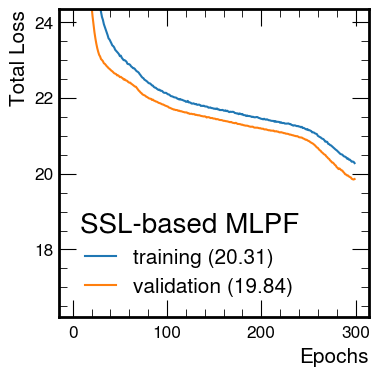

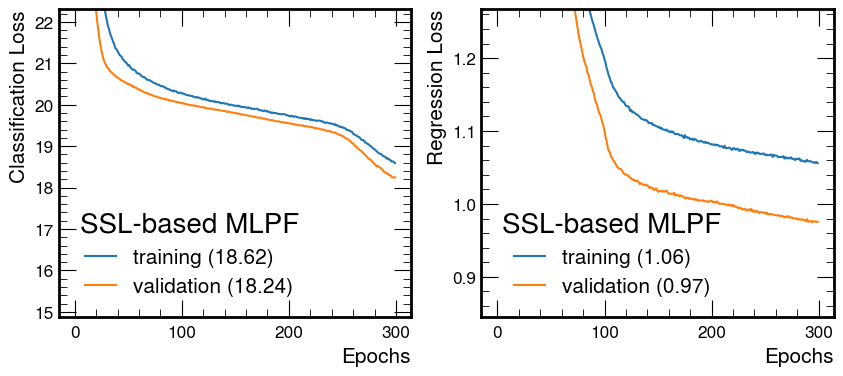

In [33]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(range(len(losses_train_tot)), losses_train_tot, label="training ({:.2f})".format(best_train_loss_tot))
ax.plot(range(len(losses_valid_tot)), losses_valid_tot, label="validation ({:.2f})".format(best_val_loss_tot))
ax.set_xlabel("Epochs")
ax.set_ylabel("Total Loss")
ax.set_ylim(0.8 * losses_train_tot[-1], 1.2 * losses_train_tot[-1])
if mode == "ssl":
    ax.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss id plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(range(len(losses_train_id)), losses_train_id, label="training ({:.2f})".format(best_train_loss_id))
ax1.plot(range(len(losses_valid_id)), losses_valid_id, label="validation ({:.2f})".format(best_val_loss_id))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Classification Loss")
ax1.set_ylim(0.8 * losses_train_id[-1], 1.2 * losses_train_id[-1])
if mode == "ssl":
    ax1.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax1.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss momentum plot
ax2.plot(
    range(len(losses_train_momentum)),
    losses_train_momentum,
    label="training ({:.2f})".format(best_train_loss_momentum),
)
ax2.plot(
    range(len(losses_valid_momentum)),
    losses_valid_momentum,
    label="validation ({:.2f})".format(best_val_loss_momentum),
)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Regression Loss")
ax2.set_ylim(0.8 * losses_train_momentum[-1], 1.2 * losses_train_momentum[-1])
if mode == "ssl":
    ax2.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax2.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

losses_to_plot["ssl"]["tot"] = losses_valid_tot
losses_to_plot["ssl"]["id"] = losses_valid_id
losses_to_plot["ssl"]["p4"] = losses_valid_momentum

In [56]:
with open(f"/pfclicvol/losses_to_plot.pkl", "wb") as f:  # dump model architecture
    pkl.dump(losses_to_plot, f, protocol=pkl.HIGHEST_PROTOCOL)

# Native

In [8]:
with open(f"/pfclicvol/losses_to_plot.pkl", "rb") as f:
    losses_to_plot = pkl.load(f)

In [34]:
ssl = 0

mlpf_model_kwargs = {
    "input_dim": input_,
    "width": 256,
    "num_convs": 0,
    "dropout": 0.4,
    "ssl": ssl,
    "VICReg_embedding_dim": 0
}

mlpf = MLPF(**mlpf_model_kwargs).to(device)
print(mlpf)

if ssl:
    mode = "ssl"
else:
    mode = "native"

MLPF(
  (nn_id): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ELU(alpha=1.0)
    (10): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ELU(alpha=1.0)
    (14): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (15): Dropout(p=0.4, inplace=False)
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): ELU(alpha=1.0)
    (18): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (19): Linear(in_features=256, out_features=6, bias=True)
 

In [35]:
n_epochs = 300
lr = 5e-5
patience = 50

def training_loop(n_epochs, lr, patience, )
    # make mlpf specific directory
    print(f"- Training {mode} MLPF over {n_epochs} epochs")

    t0_initial = time.time()

    losses_train_tot, losses_train_id, losses_train_momentum = [], [], []
    losses_valid_tot, losses_valid_id, losses_valid_momentum = [], [], []

    best_val_loss_tot, best_val_loss_id, best_val_loss_momentum = 99999.9, 99999.9, 99999.9
    stale_epochs = 0

    optimizer = torch.optim.AdamW(mlpf.parameters(), lr=lr)

    # set VICReg to evaluation mode
    encoder.eval()

    for epoch in range(n_epochs):
        t0 = time.time()

        if stale_epochs > patience:
            print("breaking due to stale epochs")
            break

        # training step
        losses_t_tot, losses_t_id, losses_t_momentum = train(
            device, encoder, mlpf, train_loader, valid_loader, optimizer, optimizer_VICReg, mode
        )
        losses_train_tot.append(losses_t_tot)
        losses_train_id.append(losses_t_id)
        losses_train_momentum.append(losses_t_momentum)

        # validation step
        losses_v_tot, losses_v_id, losses_v_momentum = validation_run(
            device, encoder, mlpf, train_loader, valid_loader, mode
        )
        losses_valid_tot.append(losses_v_tot)
        losses_valid_id.append(losses_v_id)
        losses_valid_momentum.append(losses_v_momentum)

        if losses_v_id < best_val_loss_id:
            best_val_loss_id = losses_v_id
            best_train_loss_id = losses_t_id

        if losses_v_momentum < best_val_loss_momentum:
            best_val_loss_momentum = losses_v_momentum
            best_train_loss_momentum = losses_t_momentum

        # early-stopping
        if losses_v_tot < best_val_loss_tot:
            best_val_loss_tot = losses_v_tot
            best_train_loss_tot = losses_t_tot

            stale_epochs = 0
        else:
            stale_epochs += 1

        t1 = time.time()

        epochs_remaining = n_epochs - (epoch + 1)
        time_per_epoch = (t1 - t0_initial) / (epoch + 1)
        eta = epochs_remaining * time_per_epoch / 60

        print(
            f"epoch={epoch + 1} / {n_epochs} "
            + f"train_loss={round(losses_train_tot[epoch], 4)} "
            + f"valid_loss={round(losses_valid_tot[epoch], 4)} "
            + f"stale={stale_epochs} "
            + f"time={round((t1-t0)/60, 2)}m "
            + f"eta={round(eta, 1)}m"
        )

        print("----------------------------------------------------------")
    print(f"Done with training. Total training time is {round((time.time() - t0_initial)/60,3)}min")

    return losses_valid_tot, losses_valid_id, losses_valid_momentum, losses_train_tot, losses_train_id, losses_train_momentum

- Training native MLPF over 300 epochs
Will fix VICReg during mlpf training
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.39it/s]


loss_id=73.70 loss_momentum=2.11 loss_charge=0.83
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.79it/s]


loss_id=43.73 loss_momentum=1.70 loss_charge=0.64
epoch=1 / 300 train_loss=76.6419 valid_loss=46.0732 stale=0 time=0.06m eta=18.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.80it/s]


loss_id=38.78 loss_momentum=1.85 loss_charge=0.65
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.66it/s]


loss_id=33.41 loss_momentum=1.69 loss_charge=0.63
epoch=2 / 300 train_loss=41.2865 valid_loss=35.7371 stale=0 time=0.06m eta=18.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.40it/s]


loss_id=33.30 loss_momentum=1.82 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.95it/s]


loss_id=29.97 loss_momentum=1.69 loss_charge=0.63
epoch=3 / 300 train_loss=35.7551 valid_loss=32.3008 stale=0 time=0.06m eta=18.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.45it/s]


loss_id=31.23 loss_momentum=1.81 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.89it/s]


loss_id=28.59 loss_momentum=1.69 loss_charge=0.63
epoch=4 / 300 train_loss=33.6764 valid_loss=30.9067 stale=0 time=0.06m eta=18.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.57it/s]


loss_id=30.14 loss_momentum=1.80 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.27it/s]


loss_id=27.99 loss_momentum=1.68 loss_charge=0.63
epoch=5 / 300 train_loss=32.5734 valid_loss=30.3074 stale=0 time=0.06m eta=18.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.26it/s]


loss_id=29.46 loss_momentum=1.80 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.03it/s]


loss_id=27.66 loss_momentum=1.67 loss_charge=0.63
epoch=6 / 300 train_loss=31.891 valid_loss=29.9697 stale=0 time=0.06m eta=18.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.58it/s]


loss_id=29.07 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.85it/s]


loss_id=27.49 loss_momentum=1.67 loss_charge=0.63
epoch=7 / 300 train_loss=31.4914 valid_loss=29.7855 stale=0 time=0.06m eta=18.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.28it/s]


loss_id=28.69 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.62it/s]


loss_id=27.37 loss_momentum=1.66 loss_charge=0.63
epoch=8 / 300 train_loss=31.1064 valid_loss=29.6559 stale=0 time=0.06m eta=18.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.52it/s]


loss_id=28.48 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.37it/s]


loss_id=27.23 loss_momentum=1.65 loss_charge=0.63
epoch=9 / 300 train_loss=30.8985 valid_loss=29.5162 stale=0 time=0.06m eta=18.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.10it/s]


loss_id=28.28 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.16it/s]


loss_id=27.12 loss_momentum=1.64 loss_charge=0.63
epoch=10 / 300 train_loss=30.6928 valid_loss=29.393 stale=0 time=0.06m eta=18.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.25it/s]


loss_id=28.12 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.99it/s]


loss_id=26.99 loss_momentum=1.63 loss_charge=0.63
epoch=11 / 300 train_loss=30.5221 valid_loss=29.2552 stale=0 time=0.06m eta=18.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.00it/s]


loss_id=27.96 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.73it/s]


loss_id=26.88 loss_momentum=1.63 loss_charge=0.63
epoch=12 / 300 train_loss=30.3592 valid_loss=29.14 stale=0 time=0.06m eta=18.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.19it/s]


loss_id=27.85 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.13it/s]


loss_id=26.78 loss_momentum=1.62 loss_charge=0.63
epoch=13 / 300 train_loss=30.2427 valid_loss=29.027 stale=0 time=0.06m eta=17.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.10it/s]


loss_id=27.67 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.39it/s]

loss_id=26.64 loss_momentum=1.61 loss_charge=0.63
epoch=14 / 300 train_loss=30.056 valid_loss=28.8807 stale=0 time=0.06m eta=17.9m
----------------------------------------------------------
---->Initiating a training run



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.35it/s]


loss_id=27.60 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.40it/s]


loss_id=26.53 loss_momentum=1.60 loss_charge=0.63
epoch=15 / 300 train_loss=29.9712 valid_loss=28.7614 stale=0 time=0.06m eta=17.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.31it/s]


loss_id=27.48 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.03it/s]


loss_id=26.40 loss_momentum=1.59 loss_charge=0.63
epoch=16 / 300 train_loss=29.8485 valid_loss=28.6234 stale=0 time=0.06m eta=17.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.92it/s]


loss_id=27.38 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.68it/s]


loss_id=26.28 loss_momentum=1.58 loss_charge=0.63
epoch=17 / 300 train_loss=29.736 valid_loss=28.4921 stale=0 time=0.06m eta=17.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.20it/s]


loss_id=27.26 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.32it/s]


loss_id=26.12 loss_momentum=1.57 loss_charge=0.63
epoch=18 / 300 train_loss=29.6108 valid_loss=28.3245 stale=0 time=0.06m eta=17.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.29it/s]


loss_id=27.18 loss_momentum=1.71 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.41it/s]


loss_id=25.99 loss_momentum=1.56 loss_charge=0.63
epoch=19 / 300 train_loss=29.5144 valid_loss=28.1773 stale=0 time=0.06m eta=17.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.84it/s]


loss_id=27.06 loss_momentum=1.70 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.33it/s]


loss_id=25.79 loss_momentum=1.55 loss_charge=0.63
epoch=20 / 300 train_loss=29.3875 valid_loss=27.9758 stale=0 time=0.06m eta=17.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.27it/s]


loss_id=26.94 loss_momentum=1.69 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.43it/s]


loss_id=25.66 loss_momentum=1.54 loss_charge=0.63
epoch=21 / 300 train_loss=29.2597 valid_loss=27.8294 stale=0 time=0.06m eta=17.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.20it/s]


loss_id=26.85 loss_momentum=1.68 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.99it/s]


loss_id=25.48 loss_momentum=1.53 loss_charge=0.63
epoch=22 / 300 train_loss=29.1582 valid_loss=27.6394 stale=0 time=0.06m eta=17.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.21it/s]


loss_id=26.73 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.43it/s]


loss_id=25.29 loss_momentum=1.52 loss_charge=0.63
epoch=23 / 300 train_loss=29.0363 valid_loss=27.4438 stale=0 time=0.06m eta=17.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.14it/s]


loss_id=26.60 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.76it/s]


loss_id=25.13 loss_momentum=1.52 loss_charge=0.63
epoch=24 / 300 train_loss=28.8979 valid_loss=27.2761 stale=0 time=0.06m eta=17.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.42it/s]


loss_id=26.51 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.64it/s]


loss_id=24.95 loss_momentum=1.51 loss_charge=0.63
epoch=25 / 300 train_loss=28.8019 valid_loss=27.0986 stale=0 time=0.06m eta=17.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.31it/s]


loss_id=26.39 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.20it/s]


loss_id=24.76 loss_momentum=1.51 loss_charge=0.63
epoch=26 / 300 train_loss=28.6724 valid_loss=26.8965 stale=0 time=0.06m eta=17.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.34it/s]


loss_id=26.27 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.20it/s]


loss_id=24.60 loss_momentum=1.50 loss_charge=0.63
epoch=27 / 300 train_loss=28.5519 valid_loss=26.7299 stale=0 time=0.06m eta=17.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.57it/s]


loss_id=26.14 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.33it/s]


loss_id=24.40 loss_momentum=1.50 loss_charge=0.63
epoch=28 / 300 train_loss=28.4184 valid_loss=26.5324 stale=0 time=0.06m eta=17.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.30it/s]


loss_id=26.04 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.69it/s]


loss_id=24.23 loss_momentum=1.50 loss_charge=0.63
epoch=29 / 300 train_loss=28.3128 valid_loss=26.3599 stale=0 time=0.06m eta=17.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.23it/s]


loss_id=25.90 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.78it/s]


loss_id=24.06 loss_momentum=1.50 loss_charge=0.63
epoch=30 / 300 train_loss=28.1725 valid_loss=26.1857 stale=0 time=0.06m eta=16.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.15it/s]


loss_id=25.79 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.15it/s]


loss_id=23.90 loss_momentum=1.49 loss_charge=0.63
epoch=31 / 300 train_loss=28.0576 valid_loss=26.0257 stale=0 time=0.06m eta=16.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.29it/s]


loss_id=25.64 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.96it/s]


loss_id=23.73 loss_momentum=1.49 loss_charge=0.63
epoch=32 / 300 train_loss=27.8996 valid_loss=25.8546 stale=0 time=0.06m eta=16.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.50it/s]


loss_id=25.49 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.78it/s]


loss_id=23.59 loss_momentum=1.49 loss_charge=0.63
epoch=33 / 300 train_loss=27.7491 valid_loss=25.7092 stale=0 time=0.06m eta=16.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.57it/s]


loss_id=25.40 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.66it/s]


loss_id=23.46 loss_momentum=1.49 loss_charge=0.63
epoch=34 / 300 train_loss=27.6533 valid_loss=25.5815 stale=0 time=0.06m eta=16.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.42it/s]


loss_id=25.29 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.81it/s]


loss_id=23.37 loss_momentum=1.49 loss_charge=0.63
epoch=35 / 300 train_loss=27.5434 valid_loss=25.4953 stale=0 time=0.06m eta=16.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.34it/s]


loss_id=25.18 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.48it/s]


loss_id=23.19 loss_momentum=1.49 loss_charge=0.63
epoch=36 / 300 train_loss=27.4373 valid_loss=25.3055 stale=0 time=0.06m eta=16.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.39it/s]


loss_id=25.07 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.96it/s]


loss_id=23.08 loss_momentum=1.49 loss_charge=0.63
epoch=37 / 300 train_loss=27.3204 valid_loss=25.2035 stale=0 time=0.06m eta=16.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.04it/s]


loss_id=24.95 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.80it/s]


loss_id=23.01 loss_momentum=1.49 loss_charge=0.63
epoch=38 / 300 train_loss=27.2042 valid_loss=25.124 stale=0 time=0.06m eta=16.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.23it/s]


loss_id=24.82 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.30it/s]


loss_id=22.90 loss_momentum=1.49 loss_charge=0.63
epoch=39 / 300 train_loss=27.0654 valid_loss=25.0178 stale=0 time=0.06m eta=16.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.37it/s]


loss_id=24.68 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.85it/s]


loss_id=22.74 loss_momentum=1.49 loss_charge=0.63
epoch=40 / 300 train_loss=26.9297 valid_loss=24.854 stale=0 time=0.06m eta=16.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.44it/s]


loss_id=24.60 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.93it/s]


loss_id=22.61 loss_momentum=1.48 loss_charge=0.63
epoch=41 / 300 train_loss=26.8463 valid_loss=24.7237 stale=0 time=0.06m eta=16.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.14it/s]


loss_id=24.46 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.17it/s]


loss_id=22.59 loss_momentum=1.48 loss_charge=0.63
epoch=42 / 300 train_loss=26.7091 valid_loss=24.7049 stale=0 time=0.06m eta=16.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.29it/s]


loss_id=24.36 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.24it/s]


loss_id=22.45 loss_momentum=1.48 loss_charge=0.63
epoch=43 / 300 train_loss=26.602 valid_loss=24.5679 stale=0 time=0.06m eta=16.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.28it/s]


loss_id=24.25 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.09it/s]


loss_id=22.35 loss_momentum=1.48 loss_charge=0.63
epoch=44 / 300 train_loss=26.4878 valid_loss=24.459 stale=0 time=0.06m eta=16.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.21it/s]


loss_id=24.12 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.50it/s]

loss_id=22.23 loss_momentum=1.48 loss_charge=0.63
epoch=45 / 300 train_loss=26.3564 valid_loss=24.3451 stale=0 time=0.06m eta=16.0m
----------------------------------------------------------
---->Initiating a training run



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.41it/s]


loss_id=24.03 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.72it/s]


loss_id=22.15 loss_momentum=1.48 loss_charge=0.63
epoch=46 / 300 train_loss=26.2667 valid_loss=24.2579 stale=0 time=0.06m eta=15.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.33it/s]


loss_id=23.92 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.46it/s]


loss_id=22.07 loss_momentum=1.48 loss_charge=0.63
epoch=47 / 300 train_loss=26.1562 valid_loss=24.1842 stale=0 time=0.06m eta=15.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.31it/s]


loss_id=23.81 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.56it/s]

loss_id=21.95 loss_momentum=1.48 loss_charge=0.63
epoch=48 / 300 train_loss=26.0442 valid_loss=24.0656 stale=0 time=0.06m eta=15.8m
----------------------------------------------------------
---->Initiating a training run



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.40it/s]


loss_id=23.72 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.62it/s]


loss_id=21.90 loss_momentum=1.48 loss_charge=0.63
epoch=49 / 300 train_loss=25.9543 valid_loss=24.01 stale=0 time=0.06m eta=15.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.42it/s]


loss_id=23.58 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.41it/s]


loss_id=21.81 loss_momentum=1.48 loss_charge=0.63
epoch=50 / 300 train_loss=25.8155 valid_loss=23.9245 stale=0 time=0.06m eta=15.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.57it/s]


loss_id=23.50 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.91it/s]


loss_id=21.75 loss_momentum=1.48 loss_charge=0.63
epoch=51 / 300 train_loss=25.7306 valid_loss=23.8634 stale=0 time=0.06m eta=15.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.88it/s]


loss_id=23.38 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.69it/s]


loss_id=21.67 loss_momentum=1.48 loss_charge=0.63
epoch=52 / 300 train_loss=25.6141 valid_loss=23.7762 stale=0 time=0.06m eta=15.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.62it/s]


loss_id=23.32 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.25it/s]


loss_id=21.63 loss_momentum=1.48 loss_charge=0.63
epoch=53 / 300 train_loss=25.5508 valid_loss=23.7383 stale=0 time=0.06m eta=15.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.33it/s]


loss_id=23.21 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.95it/s]


loss_id=21.53 loss_momentum=1.48 loss_charge=0.63
epoch=54 / 300 train_loss=25.4414 valid_loss=23.6381 stale=0 time=0.06m eta=15.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.39it/s]


loss_id=23.14 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.17it/s]


loss_id=21.51 loss_momentum=1.48 loss_charge=0.63
epoch=55 / 300 train_loss=25.3671 valid_loss=23.6141 stale=0 time=0.06m eta=15.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.46it/s]


loss_id=23.05 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.81it/s]


loss_id=21.42 loss_momentum=1.48 loss_charge=0.63
epoch=56 / 300 train_loss=25.2794 valid_loss=23.5296 stale=0 time=0.06m eta=15.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.52it/s]


loss_id=22.96 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.67it/s]


loss_id=21.37 loss_momentum=1.47 loss_charge=0.63
epoch=57 / 300 train_loss=25.1864 valid_loss=23.4782 stale=0 time=0.06m eta=15.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.64it/s]


loss_id=22.88 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.90it/s]


loss_id=21.36 loss_momentum=1.47 loss_charge=0.63
epoch=58 / 300 train_loss=25.1081 valid_loss=23.4692 stale=0 time=0.06m eta=15.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.37it/s]


loss_id=22.81 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.91it/s]


loss_id=21.24 loss_momentum=1.47 loss_charge=0.63
epoch=59 / 300 train_loss=25.0315 valid_loss=23.3433 stale=0 time=0.06m eta=15.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.50it/s]


loss_id=22.72 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.93it/s]


loss_id=21.22 loss_momentum=1.47 loss_charge=0.63
epoch=60 / 300 train_loss=24.9403 valid_loss=23.3194 stale=0 time=0.06m eta=15.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.22it/s]


loss_id=22.66 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.12it/s]


loss_id=21.17 loss_momentum=1.47 loss_charge=0.63
epoch=61 / 300 train_loss=24.8858 valid_loss=23.2741 stale=0 time=0.06m eta=14.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.71it/s]


loss_id=22.57 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.36it/s]


loss_id=21.13 loss_momentum=1.47 loss_charge=0.63
epoch=62 / 300 train_loss=24.7934 valid_loss=23.2262 stale=0 time=0.06m eta=14.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.28it/s]


loss_id=22.53 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.54it/s]

loss_id=21.08 loss_momentum=1.47 loss_charge=0.63
epoch=63 / 300 train_loss=24.7466 valid_loss=23.1759 stale=0 time=0.06m eta=14.8m
----------------------------------------------------------
---->Initiating a training run



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.82it/s]


loss_id=22.44 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.33it/s]


loss_id=21.05 loss_momentum=1.47 loss_charge=0.63
epoch=64 / 300 train_loss=24.6596 valid_loss=23.149 stale=0 time=0.06m eta=14.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.39it/s]


loss_id=22.36 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.22it/s]


loss_id=21.00 loss_momentum=1.47 loss_charge=0.63
epoch=65 / 300 train_loss=24.5788 valid_loss=23.0985 stale=0 time=0.06m eta=14.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.47it/s]


loss_id=22.27 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.90it/s]


loss_id=20.95 loss_momentum=1.47 loss_charge=0.63
epoch=66 / 300 train_loss=24.4921 valid_loss=23.0508 stale=0 time=0.06m eta=14.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.94it/s]


loss_id=22.21 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.64it/s]


loss_id=20.96 loss_momentum=1.47 loss_charge=0.63
epoch=67 / 300 train_loss=24.4262 valid_loss=23.0567 stale=1 time=0.06m eta=14.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.73it/s]


loss_id=22.16 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.72it/s]


loss_id=20.90 loss_momentum=1.46 loss_charge=0.63
epoch=68 / 300 train_loss=24.378 valid_loss=22.9968 stale=0 time=0.06m eta=14.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.42it/s]


loss_id=22.11 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.16it/s]


loss_id=20.85 loss_momentum=1.46 loss_charge=0.63
epoch=69 / 300 train_loss=24.3212 valid_loss=22.9485 stale=0 time=0.07m eta=14.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.37it/s]


loss_id=22.03 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 35.46it/s]


loss_id=20.84 loss_momentum=1.46 loss_charge=0.63
epoch=70 / 300 train_loss=24.2414 valid_loss=22.9316 stale=0 time=0.07m eta=14.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.60it/s]


loss_id=22.00 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.17it/s]


loss_id=20.81 loss_momentum=1.46 loss_charge=0.63
epoch=71 / 300 train_loss=24.2129 valid_loss=22.9017 stale=0 time=0.07m eta=14.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.31it/s]


loss_id=21.92 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.68it/s]


loss_id=20.79 loss_momentum=1.46 loss_charge=0.63
epoch=72 / 300 train_loss=24.1279 valid_loss=22.8752 stale=0 time=0.07m eta=14.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.62it/s]


loss_id=21.86 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.81it/s]


loss_id=20.76 loss_momentum=1.46 loss_charge=0.63
epoch=73 / 300 train_loss=24.0633 valid_loss=22.8509 stale=0 time=0.07m eta=14.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.77it/s]


loss_id=21.82 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.24it/s]


loss_id=20.74 loss_momentum=1.45 loss_charge=0.63
epoch=74 / 300 train_loss=24.026 valid_loss=22.8197 stale=0 time=0.06m eta=14.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.69it/s]


loss_id=21.77 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.16it/s]


loss_id=20.73 loss_momentum=1.45 loss_charge=0.63
epoch=75 / 300 train_loss=23.9676 valid_loss=22.8127 stale=0 time=0.06m eta=14.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.87it/s]


loss_id=21.71 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.22it/s]


loss_id=20.68 loss_momentum=1.45 loss_charge=0.63
epoch=76 / 300 train_loss=23.9079 valid_loss=22.7627 stale=0 time=0.06m eta=14.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.46it/s]


loss_id=21.65 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.05it/s]


loss_id=20.67 loss_momentum=1.45 loss_charge=0.63
epoch=77 / 300 train_loss=23.8522 valid_loss=22.7488 stale=0 time=0.06m eta=14.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.69it/s]


loss_id=21.60 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.35it/s]


loss_id=20.64 loss_momentum=1.45 loss_charge=0.63
epoch=78 / 300 train_loss=23.794 valid_loss=22.7211 stale=0 time=0.06m eta=13.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.55it/s]


loss_id=21.56 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.96it/s]


loss_id=20.62 loss_momentum=1.44 loss_charge=0.63
epoch=79 / 300 train_loss=23.7592 valid_loss=22.6952 stale=0 time=0.06m eta=13.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.05it/s]


loss_id=21.52 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.62it/s]


loss_id=20.61 loss_momentum=1.44 loss_charge=0.63
epoch=80 / 300 train_loss=23.7167 valid_loss=22.6879 stale=0 time=0.06m eta=13.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.47it/s]


loss_id=21.47 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.72it/s]


loss_id=20.59 loss_momentum=1.44 loss_charge=0.63
epoch=81 / 300 train_loss=23.6642 valid_loss=22.6608 stale=0 time=0.06m eta=13.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.53it/s]


loss_id=21.43 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.85it/s]


loss_id=20.58 loss_momentum=1.44 loss_charge=0.63
epoch=82 / 300 train_loss=23.6248 valid_loss=22.6551 stale=0 time=0.06m eta=13.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.44it/s]


loss_id=21.38 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.87it/s]


loss_id=20.56 loss_momentum=1.44 loss_charge=0.63
epoch=83 / 300 train_loss=23.5741 valid_loss=22.6333 stale=0 time=0.06m eta=13.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.12it/s]


loss_id=21.38 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.93it/s]


loss_id=20.55 loss_momentum=1.44 loss_charge=0.63
epoch=84 / 300 train_loss=23.568 valid_loss=22.6148 stale=0 time=0.06m eta=13.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.01it/s]


loss_id=21.34 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.63it/s]

loss_id=20.53 loss_momentum=1.44 loss_charge=0.63
epoch=85 / 300 train_loss=23.5222 valid_loss=22.5965 stale=0 time=0.06m eta=13.5m
----------------------------------------------------------
---->Initiating a training run



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.52it/s]


loss_id=21.30 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.43it/s]


loss_id=20.52 loss_momentum=1.44 loss_charge=0.63
epoch=86 / 300 train_loss=23.487 valid_loss=22.5859 stale=0 time=0.06m eta=13.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.31it/s]


loss_id=21.27 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.26it/s]


loss_id=20.51 loss_momentum=1.43 loss_charge=0.63
epoch=87 / 300 train_loss=23.4529 valid_loss=22.5792 stale=0 time=0.06m eta=13.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.44it/s]


loss_id=21.24 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.00it/s]


loss_id=20.51 loss_momentum=1.43 loss_charge=0.63
epoch=88 / 300 train_loss=23.4243 valid_loss=22.5773 stale=0 time=0.06m eta=13.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.26it/s]


loss_id=21.22 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.30it/s]


loss_id=20.51 loss_momentum=1.43 loss_charge=0.63
epoch=89 / 300 train_loss=23.3963 valid_loss=22.5703 stale=0 time=0.06m eta=13.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.46it/s]


loss_id=21.18 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.37it/s]


loss_id=20.47 loss_momentum=1.43 loss_charge=0.63
epoch=90 / 300 train_loss=23.3554 valid_loss=22.5341 stale=0 time=0.06m eta=13.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.38it/s]


loss_id=21.17 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.14it/s]


loss_id=20.47 loss_momentum=1.43 loss_charge=0.63
epoch=91 / 300 train_loss=23.3463 valid_loss=22.5311 stale=0 time=0.06m eta=13.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.54it/s]


loss_id=21.13 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.92it/s]


loss_id=20.46 loss_momentum=1.43 loss_charge=0.63
epoch=92 / 300 train_loss=23.2996 valid_loss=22.5188 stale=0 time=0.06m eta=13.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.70it/s]


loss_id=21.11 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.38it/s]


loss_id=20.44 loss_momentum=1.43 loss_charge=0.63
epoch=93 / 300 train_loss=23.2795 valid_loss=22.5005 stale=0 time=0.06m eta=13.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.61it/s]


loss_id=21.10 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.10it/s]


loss_id=20.44 loss_momentum=1.43 loss_charge=0.63
epoch=94 / 300 train_loss=23.2732 valid_loss=22.496 stale=0 time=0.06m eta=12.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.54it/s]


loss_id=21.07 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.85it/s]


loss_id=20.44 loss_momentum=1.43 loss_charge=0.63
epoch=95 / 300 train_loss=23.2376 valid_loss=22.4982 stale=1 time=0.06m eta=12.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.59it/s]


loss_id=21.08 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.23it/s]


loss_id=20.42 loss_momentum=1.42 loss_charge=0.63
epoch=96 / 300 train_loss=23.2446 valid_loss=22.4778 stale=0 time=0.06m eta=12.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.17it/s]


loss_id=21.03 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.14it/s]


loss_id=20.42 loss_momentum=1.42 loss_charge=0.63
epoch=97 / 300 train_loss=23.2006 valid_loss=22.4748 stale=0 time=0.06m eta=12.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.32it/s]


loss_id=21.01 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.62it/s]


loss_id=20.41 loss_momentum=1.42 loss_charge=0.63
epoch=98 / 300 train_loss=23.176 valid_loss=22.4633 stale=0 time=0.06m eta=12.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.02it/s]


loss_id=21.00 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.07it/s]


loss_id=20.40 loss_momentum=1.42 loss_charge=0.63
epoch=99 / 300 train_loss=23.1612 valid_loss=22.4487 stale=0 time=0.06m eta=12.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.43it/s]


loss_id=20.98 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.58it/s]


loss_id=20.40 loss_momentum=1.42 loss_charge=0.63
epoch=100 / 300 train_loss=23.147 valid_loss=22.4529 stale=1 time=0.06m eta=12.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.16it/s]


loss_id=20.94 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.69it/s]


loss_id=20.39 loss_momentum=1.42 loss_charge=0.63
epoch=101 / 300 train_loss=23.1065 valid_loss=22.4461 stale=0 time=0.06m eta=12.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.37it/s]


loss_id=20.94 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.70it/s]


loss_id=20.36 loss_momentum=1.42 loss_charge=0.63
epoch=102 / 300 train_loss=23.1019 valid_loss=22.4096 stale=0 time=0.06m eta=12.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.50it/s]


loss_id=20.93 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.35it/s]


loss_id=20.37 loss_momentum=1.42 loss_charge=0.63
epoch=103 / 300 train_loss=23.0885 valid_loss=22.4185 stale=1 time=0.06m eta=12.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.54it/s]


loss_id=20.91 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.41it/s]


loss_id=20.34 loss_momentum=1.42 loss_charge=0.63
epoch=104 / 300 train_loss=23.0752 valid_loss=22.3946 stale=0 time=0.06m eta=12.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.43it/s]


loss_id=20.89 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.27it/s]


loss_id=20.37 loss_momentum=1.42 loss_charge=0.63
epoch=105 / 300 train_loss=23.0487 valid_loss=22.4175 stale=1 time=0.06m eta=12.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.34it/s]


loss_id=20.88 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.14it/s]


loss_id=20.35 loss_momentum=1.42 loss_charge=0.63
epoch=106 / 300 train_loss=23.037 valid_loss=22.4013 stale=2 time=0.06m eta=12.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.76it/s]


loss_id=20.89 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.75it/s]


loss_id=20.33 loss_momentum=1.42 loss_charge=0.63
epoch=107 / 300 train_loss=23.04 valid_loss=22.3773 stale=0 time=0.06m eta=12.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.82it/s]


loss_id=20.87 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.05it/s]


loss_id=20.34 loss_momentum=1.42 loss_charge=0.63
epoch=108 / 300 train_loss=23.0228 valid_loss=22.3841 stale=1 time=0.06m eta=12.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.09it/s]


loss_id=20.83 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.48it/s]


loss_id=20.33 loss_momentum=1.42 loss_charge=0.63
epoch=109 / 300 train_loss=22.9826 valid_loss=22.3782 stale=2 time=0.06m eta=12.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.23it/s]


loss_id=20.82 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.00it/s]


loss_id=20.33 loss_momentum=1.42 loss_charge=0.63
epoch=110 / 300 train_loss=22.9767 valid_loss=22.3803 stale=3 time=0.06m eta=11.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.88it/s]


loss_id=20.82 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.27it/s]


loss_id=20.31 loss_momentum=1.42 loss_charge=0.63
epoch=111 / 300 train_loss=22.9748 valid_loss=22.3565 stale=0 time=0.06m eta=11.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.36it/s]


loss_id=20.80 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.99it/s]


loss_id=20.31 loss_momentum=1.41 loss_charge=0.63
epoch=112 / 300 train_loss=22.9473 valid_loss=22.3527 stale=0 time=0.06m eta=11.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.63it/s]


loss_id=20.80 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.01it/s]


loss_id=20.32 loss_momentum=1.41 loss_charge=0.63
epoch=113 / 300 train_loss=22.9487 valid_loss=22.3604 stale=1 time=0.06m eta=11.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.30it/s]


loss_id=20.79 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.27it/s]


loss_id=20.30 loss_momentum=1.41 loss_charge=0.63
epoch=114 / 300 train_loss=22.9368 valid_loss=22.3429 stale=0 time=0.06m eta=11.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.67it/s]


loss_id=20.77 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.14it/s]


loss_id=20.30 loss_momentum=1.41 loss_charge=0.63
epoch=115 / 300 train_loss=22.9158 valid_loss=22.3443 stale=1 time=0.06m eta=11.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.61it/s]


loss_id=20.77 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.54it/s]


loss_id=20.30 loss_momentum=1.41 loss_charge=0.63
epoch=116 / 300 train_loss=22.9153 valid_loss=22.3402 stale=0 time=0.06m eta=11.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.57it/s]


loss_id=20.74 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.07it/s]


loss_id=20.30 loss_momentum=1.41 loss_charge=0.63
epoch=117 / 300 train_loss=22.8887 valid_loss=22.3382 stale=0 time=0.06m eta=11.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.18it/s]


loss_id=20.76 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.76it/s]


loss_id=20.29 loss_momentum=1.41 loss_charge=0.63
epoch=118 / 300 train_loss=22.9086 valid_loss=22.3269 stale=0 time=0.06m eta=11.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.49it/s]


loss_id=20.74 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.14it/s]


loss_id=20.27 loss_momentum=1.41 loss_charge=0.63
epoch=119 / 300 train_loss=22.8826 valid_loss=22.3086 stale=0 time=0.06m eta=11.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.22it/s]


loss_id=20.74 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.21it/s]


loss_id=20.26 loss_momentum=1.41 loss_charge=0.63
epoch=120 / 300 train_loss=22.8822 valid_loss=22.2994 stale=0 time=0.06m eta=11.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.52it/s]


loss_id=20.70 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.26it/s]


loss_id=20.26 loss_momentum=1.41 loss_charge=0.63
epoch=121 / 300 train_loss=22.8374 valid_loss=22.3005 stale=1 time=0.06m eta=11.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.69it/s]


loss_id=20.70 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.23it/s]


loss_id=20.25 loss_momentum=1.41 loss_charge=0.63
epoch=122 / 300 train_loss=22.8443 valid_loss=22.2919 stale=0 time=0.06m eta=11.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.62it/s]


loss_id=20.69 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.87it/s]


loss_id=20.26 loss_momentum=1.41 loss_charge=0.63
epoch=123 / 300 train_loss=22.8296 valid_loss=22.2927 stale=1 time=0.06m eta=11.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.66it/s]


loss_id=20.68 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.59it/s]


loss_id=20.24 loss_momentum=1.40 loss_charge=0.63
epoch=124 / 300 train_loss=22.8203 valid_loss=22.2769 stale=0 time=0.06m eta=11.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.78it/s]


loss_id=20.67 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.51it/s]


loss_id=20.24 loss_momentum=1.40 loss_charge=0.63
epoch=125 / 300 train_loss=22.8091 valid_loss=22.2714 stale=0 time=0.06m eta=11.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.12it/s]


loss_id=20.67 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.41it/s]


loss_id=20.23 loss_momentum=1.40 loss_charge=0.63
epoch=126 / 300 train_loss=22.8062 valid_loss=22.2623 stale=0 time=0.06m eta=10.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.00it/s]


loss_id=20.66 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.90it/s]


loss_id=20.23 loss_momentum=1.40 loss_charge=0.63
epoch=127 / 300 train_loss=22.7967 valid_loss=22.2626 stale=1 time=0.06m eta=10.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.55it/s]


loss_id=20.66 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.20it/s]


loss_id=20.22 loss_momentum=1.40 loss_charge=0.63
epoch=128 / 300 train_loss=22.7944 valid_loss=22.249 stale=0 time=0.07m eta=10.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.01it/s]


loss_id=20.65 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.48it/s]


loss_id=20.23 loss_momentum=1.40 loss_charge=0.63
epoch=129 / 300 train_loss=22.783 valid_loss=22.2571 stale=1 time=0.06m eta=10.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.53it/s]


loss_id=20.65 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.11it/s]


loss_id=20.22 loss_momentum=1.40 loss_charge=0.63
epoch=130 / 300 train_loss=22.7821 valid_loss=22.2482 stale=0 time=0.07m eta=10.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.31it/s]


loss_id=20.63 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.92it/s]


loss_id=20.22 loss_momentum=1.40 loss_charge=0.63
epoch=131 / 300 train_loss=22.761 valid_loss=22.25 stale=1 time=0.07m eta=10.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.07it/s]


loss_id=20.64 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.14it/s]


loss_id=20.21 loss_momentum=1.40 loss_charge=0.63
epoch=132 / 300 train_loss=22.7678 valid_loss=22.2333 stale=0 time=0.06m eta=10.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.66it/s]


loss_id=20.62 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.63it/s]


loss_id=20.20 loss_momentum=1.40 loss_charge=0.63
epoch=133 / 300 train_loss=22.7486 valid_loss=22.2288 stale=0 time=0.06m eta=10.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.09it/s]


loss_id=20.61 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.17it/s]


loss_id=20.20 loss_momentum=1.40 loss_charge=0.63
epoch=134 / 300 train_loss=22.74 valid_loss=22.2303 stale=1 time=0.06m eta=10.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.44it/s]


loss_id=20.62 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.30it/s]


loss_id=20.19 loss_momentum=1.40 loss_charge=0.63
epoch=135 / 300 train_loss=22.7451 valid_loss=22.2202 stale=0 time=0.06m eta=10.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.35it/s]


loss_id=20.60 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.82it/s]


loss_id=20.19 loss_momentum=1.39 loss_charge=0.63
epoch=136 / 300 train_loss=22.7259 valid_loss=22.2204 stale=1 time=0.06m eta=10.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.22it/s]


loss_id=20.61 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.46it/s]


loss_id=20.19 loss_momentum=1.39 loss_charge=0.63
epoch=137 / 300 train_loss=22.7382 valid_loss=22.2146 stale=0 time=0.06m eta=10.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.86it/s]


loss_id=20.59 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.21it/s]


loss_id=20.18 loss_momentum=1.39 loss_charge=0.63
epoch=138 / 300 train_loss=22.7208 valid_loss=22.1989 stale=0 time=0.06m eta=10.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.72it/s]


loss_id=20.58 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.45it/s]


loss_id=20.18 loss_momentum=1.39 loss_charge=0.63
epoch=139 / 300 train_loss=22.7042 valid_loss=22.2026 stale=1 time=0.06m eta=10.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.00it/s]


loss_id=20.57 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.49it/s]


loss_id=20.17 loss_momentum=1.39 loss_charge=0.63
epoch=140 / 300 train_loss=22.7017 valid_loss=22.1969 stale=0 time=0.06m eta=10.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.98it/s]


loss_id=20.58 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.44it/s]


loss_id=20.17 loss_momentum=1.39 loss_charge=0.63
epoch=141 / 300 train_loss=22.7012 valid_loss=22.1886 stale=0 time=0.06m eta=10.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.31it/s]


loss_id=20.56 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.44it/s]


loss_id=20.16 loss_momentum=1.39 loss_charge=0.63
epoch=142 / 300 train_loss=22.6867 valid_loss=22.1822 stale=0 time=0.06m eta=9.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.41it/s]


loss_id=20.56 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.67it/s]


loss_id=20.16 loss_momentum=1.39 loss_charge=0.63
epoch=143 / 300 train_loss=22.6855 valid_loss=22.1841 stale=1 time=0.06m eta=9.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.06it/s]


loss_id=20.54 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.56it/s]


loss_id=20.17 loss_momentum=1.39 loss_charge=0.63
epoch=144 / 300 train_loss=22.6639 valid_loss=22.1876 stale=2 time=0.06m eta=9.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.33it/s]


loss_id=20.53 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.56it/s]


loss_id=20.16 loss_momentum=1.39 loss_charge=0.63
epoch=145 / 300 train_loss=22.6523 valid_loss=22.1772 stale=0 time=0.06m eta=9.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.71it/s]


loss_id=20.55 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.99it/s]


loss_id=20.15 loss_momentum=1.39 loss_charge=0.63
epoch=146 / 300 train_loss=22.6676 valid_loss=22.1719 stale=0 time=0.06m eta=9.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.50it/s]


loss_id=20.53 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.40it/s]


loss_id=20.15 loss_momentum=1.39 loss_charge=0.63
epoch=147 / 300 train_loss=22.6513 valid_loss=22.1635 stale=0 time=0.06m eta=9.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.33it/s]


loss_id=20.52 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.28it/s]


loss_id=20.15 loss_momentum=1.39 loss_charge=0.63
epoch=148 / 300 train_loss=22.6389 valid_loss=22.1663 stale=1 time=0.06m eta=9.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.14it/s]


loss_id=20.52 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.99it/s]


loss_id=20.14 loss_momentum=1.39 loss_charge=0.63
epoch=149 / 300 train_loss=22.6381 valid_loss=22.154 stale=0 time=0.06m eta=9.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.87it/s]


loss_id=20.51 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.39it/s]


loss_id=20.13 loss_momentum=1.39 loss_charge=0.63
epoch=150 / 300 train_loss=22.6269 valid_loss=22.1494 stale=0 time=0.06m eta=9.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.26it/s]


loss_id=20.51 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.06it/s]


loss_id=20.13 loss_momentum=1.38 loss_charge=0.63
epoch=151 / 300 train_loss=22.6271 valid_loss=22.1442 stale=0 time=0.06m eta=9.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.03it/s]


loss_id=20.49 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.33it/s]


loss_id=20.13 loss_momentum=1.38 loss_charge=0.63
epoch=152 / 300 train_loss=22.6085 valid_loss=22.1449 stale=1 time=0.06m eta=9.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.62it/s]


loss_id=20.50 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.37it/s]


loss_id=20.13 loss_momentum=1.38 loss_charge=0.63
epoch=153 / 300 train_loss=22.6146 valid_loss=22.1391 stale=0 time=0.06m eta=9.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.73it/s]


loss_id=20.51 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.75it/s]


loss_id=20.11 loss_momentum=1.38 loss_charge=0.63
epoch=154 / 300 train_loss=22.6222 valid_loss=22.1269 stale=0 time=0.06m eta=9.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.59it/s]


loss_id=20.50 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.93it/s]


loss_id=20.11 loss_momentum=1.38 loss_charge=0.63
epoch=155 / 300 train_loss=22.6079 valid_loss=22.1246 stale=0 time=0.06m eta=9.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.54it/s]


loss_id=20.50 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.76it/s]


loss_id=20.10 loss_momentum=1.38 loss_charge=0.63
epoch=156 / 300 train_loss=22.614 valid_loss=22.1145 stale=0 time=0.06m eta=9.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.44it/s]


loss_id=20.47 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.40it/s]


loss_id=20.12 loss_momentum=1.38 loss_charge=0.63
epoch=157 / 300 train_loss=22.5777 valid_loss=22.1288 stale=1 time=0.06m eta=9.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.83it/s]


loss_id=20.46 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.41it/s]


loss_id=20.12 loss_momentum=1.38 loss_charge=0.63
epoch=158 / 300 train_loss=22.5741 valid_loss=22.1288 stale=2 time=0.06m eta=8.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.71it/s]


loss_id=20.48 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.25it/s]


loss_id=20.10 loss_momentum=1.38 loss_charge=0.63
epoch=159 / 300 train_loss=22.5894 valid_loss=22.1061 stale=0 time=0.06m eta=8.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.85it/s]


loss_id=20.45 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.44it/s]


loss_id=20.10 loss_momentum=1.38 loss_charge=0.63
epoch=160 / 300 train_loss=22.5627 valid_loss=22.1071 stale=1 time=0.06m eta=8.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.55it/s]


loss_id=20.46 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.39it/s]


loss_id=20.10 loss_momentum=1.38 loss_charge=0.63
epoch=161 / 300 train_loss=22.5707 valid_loss=22.1078 stale=2 time=0.06m eta=8.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.74it/s]


loss_id=20.46 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.47it/s]


loss_id=20.10 loss_momentum=1.38 loss_charge=0.63
epoch=162 / 300 train_loss=22.57 valid_loss=22.1127 stale=3 time=0.06m eta=8.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.78it/s]


loss_id=20.45 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.46it/s]


loss_id=20.10 loss_momentum=1.37 loss_charge=0.63
epoch=163 / 300 train_loss=22.5618 valid_loss=22.1024 stale=0 time=0.06m eta=8.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.59it/s]


loss_id=20.44 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.39it/s]


loss_id=20.08 loss_momentum=1.37 loss_charge=0.63
epoch=164 / 300 train_loss=22.5472 valid_loss=22.0857 stale=0 time=0.06m eta=8.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.80it/s]


loss_id=20.45 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.88it/s]


loss_id=20.09 loss_momentum=1.37 loss_charge=0.63
epoch=165 / 300 train_loss=22.5541 valid_loss=22.0906 stale=1 time=0.06m eta=8.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.31it/s]


loss_id=20.45 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.72it/s]


loss_id=20.08 loss_momentum=1.37 loss_charge=0.63
epoch=166 / 300 train_loss=22.5563 valid_loss=22.083 stale=0 time=0.06m eta=8.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.24it/s]


loss_id=20.44 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.21it/s]


loss_id=20.07 loss_momentum=1.37 loss_charge=0.63
epoch=167 / 300 train_loss=22.5421 valid_loss=22.0733 stale=0 time=0.06m eta=8.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.47it/s]


loss_id=20.43 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.93it/s]


loss_id=20.08 loss_momentum=1.37 loss_charge=0.63
epoch=168 / 300 train_loss=22.5391 valid_loss=22.0847 stale=1 time=0.06m eta=8.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.49it/s]


loss_id=20.42 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.14it/s]


loss_id=20.07 loss_momentum=1.37 loss_charge=0.63
epoch=169 / 300 train_loss=22.5232 valid_loss=22.0676 stale=0 time=0.06m eta=8.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.12it/s]


loss_id=20.43 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.09it/s]


loss_id=20.06 loss_momentum=1.37 loss_charge=0.63
epoch=170 / 300 train_loss=22.5283 valid_loss=22.0627 stale=0 time=0.06m eta=8.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.21it/s]


loss_id=20.42 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.44it/s]


loss_id=20.06 loss_momentum=1.37 loss_charge=0.63
epoch=171 / 300 train_loss=22.5186 valid_loss=22.063 stale=1 time=0.06m eta=8.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.57it/s]


loss_id=20.41 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.14it/s]


loss_id=20.06 loss_momentum=1.37 loss_charge=0.63
epoch=172 / 300 train_loss=22.5072 valid_loss=22.0572 stale=0 time=0.06m eta=8.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.59it/s]


loss_id=20.42 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.35it/s]


loss_id=20.06 loss_momentum=1.37 loss_charge=0.63
epoch=173 / 300 train_loss=22.5159 valid_loss=22.0609 stale=1 time=0.06m eta=8.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.56it/s]


loss_id=20.39 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.59it/s]


loss_id=20.06 loss_momentum=1.37 loss_charge=0.63
epoch=174 / 300 train_loss=22.4938 valid_loss=22.0547 stale=0 time=0.06m eta=7.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.65it/s]


loss_id=20.41 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.59it/s]


loss_id=20.05 loss_momentum=1.37 loss_charge=0.63
epoch=175 / 300 train_loss=22.5076 valid_loss=22.041 stale=0 time=0.06m eta=7.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.93it/s]


loss_id=20.40 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.29it/s]


loss_id=20.06 loss_momentum=1.36 loss_charge=0.63
epoch=176 / 300 train_loss=22.4992 valid_loss=22.0505 stale=1 time=0.06m eta=7.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.82it/s]


loss_id=20.41 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.25it/s]


loss_id=20.05 loss_momentum=1.36 loss_charge=0.63
epoch=177 / 300 train_loss=22.5039 valid_loss=22.0401 stale=0 time=0.06m eta=7.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.83it/s]


loss_id=20.38 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.42it/s]


loss_id=20.05 loss_momentum=1.36 loss_charge=0.63
epoch=178 / 300 train_loss=22.4722 valid_loss=22.0423 stale=1 time=0.06m eta=7.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.77it/s]


loss_id=20.38 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.99it/s]


loss_id=20.04 loss_momentum=1.36 loss_charge=0.63
epoch=179 / 300 train_loss=22.4713 valid_loss=22.0354 stale=0 time=0.06m eta=7.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.81it/s]


loss_id=20.38 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.24it/s]


loss_id=20.04 loss_momentum=1.36 loss_charge=0.63
epoch=180 / 300 train_loss=22.4718 valid_loss=22.0329 stale=0 time=0.06m eta=7.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.56it/s]


loss_id=20.39 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.77it/s]


loss_id=20.05 loss_momentum=1.36 loss_charge=0.63
epoch=181 / 300 train_loss=22.4776 valid_loss=22.0363 stale=1 time=0.06m eta=7.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.14it/s]


loss_id=20.37 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.54it/s]


loss_id=20.04 loss_momentum=1.36 loss_charge=0.63
epoch=182 / 300 train_loss=22.4591 valid_loss=22.031 stale=0 time=0.06m eta=7.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.36it/s]


loss_id=20.38 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.09it/s]


loss_id=20.03 loss_momentum=1.36 loss_charge=0.63
epoch=183 / 300 train_loss=22.4674 valid_loss=22.0155 stale=0 time=0.06m eta=7.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.60it/s]


loss_id=20.38 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.57it/s]


loss_id=20.03 loss_momentum=1.36 loss_charge=0.63
epoch=184 / 300 train_loss=22.4727 valid_loss=22.0144 stale=0 time=0.06m eta=7.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.74it/s]


loss_id=20.37 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.08it/s]


loss_id=20.02 loss_momentum=1.36 loss_charge=0.63
epoch=185 / 300 train_loss=22.4541 valid_loss=22.0096 stale=0 time=0.06m eta=7.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.51it/s]


loss_id=20.36 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.26it/s]


loss_id=20.02 loss_momentum=1.35 loss_charge=0.63
epoch=186 / 300 train_loss=22.4533 valid_loss=22.0032 stale=0 time=0.06m eta=7.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.29it/s]


loss_id=20.36 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.47it/s]


loss_id=20.02 loss_momentum=1.35 loss_charge=0.63
epoch=187 / 300 train_loss=22.4545 valid_loss=22.0023 stale=0 time=0.06m eta=7.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.59it/s]


loss_id=20.35 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.35it/s]


loss_id=20.01 loss_momentum=1.35 loss_charge=0.63
epoch=188 / 300 train_loss=22.44 valid_loss=21.9969 stale=0 time=0.06m eta=7.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.29it/s]


loss_id=20.34 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.68it/s]


loss_id=20.01 loss_momentum=1.35 loss_charge=0.63
epoch=189 / 300 train_loss=22.4295 valid_loss=21.997 stale=1 time=0.06m eta=6.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.50it/s]


loss_id=20.35 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.19it/s]


loss_id=20.01 loss_momentum=1.35 loss_charge=0.63
epoch=190 / 300 train_loss=22.4357 valid_loss=21.9901 stale=0 time=0.06m eta=6.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.19it/s]


loss_id=20.35 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.12it/s]


loss_id=20.01 loss_momentum=1.35 loss_charge=0.63
epoch=191 / 300 train_loss=22.4346 valid_loss=21.988 stale=0 time=0.06m eta=6.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.19it/s]


loss_id=20.35 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.41it/s]


loss_id=20.01 loss_momentum=1.35 loss_charge=0.63
epoch=192 / 300 train_loss=22.4314 valid_loss=21.9893 stale=1 time=0.06m eta=6.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.46it/s]


loss_id=20.35 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.80it/s]


loss_id=20.00 loss_momentum=1.35 loss_charge=0.63
epoch=193 / 300 train_loss=22.4339 valid_loss=21.9761 stale=0 time=0.07m eta=6.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.43it/s]


loss_id=20.35 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.97it/s]


loss_id=20.00 loss_momentum=1.35 loss_charge=0.63
epoch=194 / 300 train_loss=22.4328 valid_loss=21.9808 stale=1 time=0.06m eta=6.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.35it/s]


loss_id=20.34 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.78it/s]


loss_id=20.00 loss_momentum=1.35 loss_charge=0.63
epoch=195 / 300 train_loss=22.4203 valid_loss=21.9769 stale=2 time=0.06m eta=6.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.20it/s]


loss_id=20.34 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.88it/s]


loss_id=20.00 loss_momentum=1.34 loss_charge=0.63
epoch=196 / 300 train_loss=22.4211 valid_loss=21.9797 stale=3 time=0.06m eta=6.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.27it/s]


loss_id=20.33 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.71it/s]


loss_id=20.00 loss_momentum=1.34 loss_charge=0.63
epoch=197 / 300 train_loss=22.4095 valid_loss=21.9706 stale=0 time=0.06m eta=6.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.26it/s]


loss_id=20.33 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.63it/s]


loss_id=19.99 loss_momentum=1.34 loss_charge=0.63
epoch=198 / 300 train_loss=22.4126 valid_loss=21.9626 stale=0 time=0.06m eta=6.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.58it/s]


loss_id=20.31 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.33it/s]


loss_id=19.99 loss_momentum=1.34 loss_charge=0.63
epoch=199 / 300 train_loss=22.3915 valid_loss=21.9595 stale=0 time=0.06m eta=6.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.59it/s]


loss_id=20.32 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.60it/s]


loss_id=19.99 loss_momentum=1.34 loss_charge=0.63
epoch=200 / 300 train_loss=22.3946 valid_loss=21.9613 stale=1 time=0.06m eta=6.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.80it/s]


loss_id=20.32 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.89it/s]


loss_id=19.98 loss_momentum=1.34 loss_charge=0.63
epoch=201 / 300 train_loss=22.394 valid_loss=21.9461 stale=0 time=0.06m eta=6.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.82it/s]


loss_id=20.31 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.46it/s]


loss_id=19.99 loss_momentum=1.34 loss_charge=0.63
epoch=202 / 300 train_loss=22.3823 valid_loss=21.953 stale=1 time=0.06m eta=6.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.83it/s]


loss_id=20.32 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.76it/s]


loss_id=19.98 loss_momentum=1.33 loss_charge=0.63
epoch=203 / 300 train_loss=22.3927 valid_loss=21.9471 stale=2 time=0.06m eta=6.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.85it/s]


loss_id=20.31 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.31it/s]


loss_id=19.97 loss_momentum=1.33 loss_charge=0.63
epoch=204 / 300 train_loss=22.3816 valid_loss=21.9334 stale=0 time=0.06m eta=6.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.57it/s]


loss_id=20.30 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.08it/s]


loss_id=19.97 loss_momentum=1.33 loss_charge=0.63
epoch=205 / 300 train_loss=22.3756 valid_loss=21.929 stale=0 time=0.06m eta=5.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.56it/s]


loss_id=20.28 loss_momentum=1.44 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.61it/s]

loss_id=19.96 loss_momentum=1.33 loss_charge=0.63
epoch=206 / 300 train_loss=22.3536 valid_loss=21.9201 stale=0 time=0.06m eta=5.9m
----------------------------------------------------------
---->Initiating a training run



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.54it/s]


loss_id=20.30 loss_momentum=1.44 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.31it/s]


loss_id=19.98 loss_momentum=1.33 loss_charge=0.63
epoch=207 / 300 train_loss=22.372 valid_loss=21.9368 stale=1 time=0.06m eta=5.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.81it/s]


loss_id=20.30 loss_momentum=1.44 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.61it/s]


loss_id=19.96 loss_momentum=1.32 loss_charge=0.63
epoch=208 / 300 train_loss=22.3695 valid_loss=21.9184 stale=0 time=0.06m eta=5.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.45it/s]


loss_id=20.28 loss_momentum=1.44 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.38it/s]


loss_id=19.96 loss_momentum=1.32 loss_charge=0.63
epoch=209 / 300 train_loss=22.3434 valid_loss=21.9095 stale=0 time=0.06m eta=5.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.78it/s]


loss_id=20.28 loss_momentum=1.44 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.29it/s]


loss_id=19.96 loss_momentum=1.32 loss_charge=0.63
epoch=210 / 300 train_loss=22.3468 valid_loss=21.9067 stale=0 time=0.06m eta=5.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.31it/s]


loss_id=20.29 loss_momentum=1.44 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.54it/s]


loss_id=19.96 loss_momentum=1.31 loss_charge=0.63
epoch=211 / 300 train_loss=22.3581 valid_loss=21.9032 stale=0 time=0.06m eta=5.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.38it/s]


loss_id=20.29 loss_momentum=1.44 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.57it/s]


loss_id=19.95 loss_momentum=1.31 loss_charge=0.63
epoch=212 / 300 train_loss=22.3514 valid_loss=21.8908 stale=0 time=0.06m eta=5.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.72it/s]


loss_id=20.28 loss_momentum=1.43 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.94it/s]


loss_id=19.95 loss_momentum=1.31 loss_charge=0.63
epoch=213 / 300 train_loss=22.3453 valid_loss=21.8876 stale=0 time=0.06m eta=5.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.61it/s]


loss_id=20.27 loss_momentum=1.43 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.80it/s]


loss_id=19.96 loss_momentum=1.30 loss_charge=0.63
epoch=214 / 300 train_loss=22.3326 valid_loss=21.8875 stale=0 time=0.06m eta=5.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.90it/s]


loss_id=20.27 loss_momentum=1.43 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.35it/s]


loss_id=19.95 loss_momentum=1.30 loss_charge=0.63
epoch=215 / 300 train_loss=22.3262 valid_loss=21.8822 stale=0 time=0.06m eta=5.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.82it/s]


loss_id=20.27 loss_momentum=1.42 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.77it/s]


loss_id=19.95 loss_momentum=1.29 loss_charge=0.63
epoch=216 / 300 train_loss=22.3286 valid_loss=21.873 stale=0 time=0.06m eta=5.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.30it/s]


loss_id=20.27 loss_momentum=1.42 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.47it/s]


loss_id=19.95 loss_momentum=1.29 loss_charge=0.63
epoch=217 / 300 train_loss=22.3255 valid_loss=21.8734 stale=1 time=0.06m eta=5.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.58it/s]


loss_id=20.27 loss_momentum=1.42 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.89it/s]


loss_id=19.94 loss_momentum=1.29 loss_charge=0.63
epoch=218 / 300 train_loss=22.3168 valid_loss=21.8605 stale=0 time=0.06m eta=5.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.28it/s]


loss_id=20.26 loss_momentum=1.42 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.83it/s]


loss_id=19.94 loss_momentum=1.28 loss_charge=0.63
epoch=219 / 300 train_loss=22.3108 valid_loss=21.854 stale=0 time=0.06m eta=5.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.61it/s]


loss_id=20.25 loss_momentum=1.41 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.20it/s]


loss_id=19.94 loss_momentum=1.28 loss_charge=0.63
epoch=220 / 300 train_loss=22.2902 valid_loss=21.8464 stale=0 time=0.06m eta=5.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.46it/s]


loss_id=20.25 loss_momentum=1.41 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.48it/s]


loss_id=19.94 loss_momentum=1.28 loss_charge=0.63
epoch=221 / 300 train_loss=22.2925 valid_loss=21.8439 stale=0 time=0.06m eta=4.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.53it/s]


loss_id=20.25 loss_momentum=1.41 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.26it/s]


loss_id=19.93 loss_momentum=1.27 loss_charge=0.63
epoch=222 / 300 train_loss=22.2937 valid_loss=21.8327 stale=0 time=0.06m eta=4.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.37it/s]


loss_id=20.25 loss_momentum=1.41 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.93it/s]


loss_id=19.93 loss_momentum=1.27 loss_charge=0.63
epoch=223 / 300 train_loss=22.2838 valid_loss=21.8329 stale=1 time=0.06m eta=4.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.30it/s]


loss_id=20.26 loss_momentum=1.40 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.20it/s]


loss_id=19.93 loss_momentum=1.27 loss_charge=0.63
epoch=224 / 300 train_loss=22.2961 valid_loss=21.8219 stale=0 time=0.06m eta=4.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.52it/s]


loss_id=20.26 loss_momentum=1.40 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.42it/s]


loss_id=19.93 loss_momentum=1.26 loss_charge=0.63
epoch=225 / 300 train_loss=22.289 valid_loss=21.8171 stale=0 time=0.06m eta=4.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.34it/s]


loss_id=20.24 loss_momentum=1.40 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.43it/s]


loss_id=19.93 loss_momentum=1.26 loss_charge=0.63
epoch=226 / 300 train_loss=22.2676 valid_loss=21.8152 stale=0 time=0.06m eta=4.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.61it/s]


loss_id=20.24 loss_momentum=1.40 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.09it/s]


loss_id=19.93 loss_momentum=1.25 loss_charge=0.63
epoch=227 / 300 train_loss=22.2665 valid_loss=21.8115 stale=0 time=0.06m eta=4.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.82it/s]


loss_id=20.24 loss_momentum=1.39 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.81it/s]


loss_id=19.92 loss_momentum=1.25 loss_charge=0.63
epoch=228 / 300 train_loss=22.2636 valid_loss=21.802 stale=0 time=0.06m eta=4.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.71it/s]


loss_id=20.23 loss_momentum=1.39 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.49it/s]


loss_id=19.91 loss_momentum=1.25 loss_charge=0.63
epoch=229 / 300 train_loss=22.2499 valid_loss=21.7918 stale=0 time=0.06m eta=4.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.54it/s]


loss_id=20.24 loss_momentum=1.38 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.99it/s]


loss_id=19.91 loss_momentum=1.25 loss_charge=0.63
epoch=230 / 300 train_loss=22.2491 valid_loss=21.783 stale=0 time=0.06m eta=4.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.69it/s]


loss_id=20.22 loss_momentum=1.38 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.75it/s]


loss_id=19.91 loss_momentum=1.24 loss_charge=0.63
epoch=231 / 300 train_loss=22.2361 valid_loss=21.783 stale=0 time=0.06m eta=4.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.96it/s]


loss_id=20.23 loss_momentum=1.38 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.51it/s]

loss_id=19.91 loss_momentum=1.24 loss_charge=0.63
epoch=232 / 300 train_loss=22.2406 valid_loss=21.7748 stale=0 time=0.06m eta=4.2m
----------------------------------------------------------
---->Initiating a training run



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.94it/s]


loss_id=20.22 loss_momentum=1.38 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.38it/s]


loss_id=19.91 loss_momentum=1.23 loss_charge=0.63
epoch=233 / 300 train_loss=22.2239 valid_loss=21.7759 stale=1 time=0.06m eta=4.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.56it/s]


loss_id=20.22 loss_momentum=1.37 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.94it/s]


loss_id=19.92 loss_momentum=1.23 loss_charge=0.63
epoch=234 / 300 train_loss=22.2274 valid_loss=21.7806 stale=2 time=0.06m eta=4.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.85it/s]


loss_id=20.23 loss_momentum=1.37 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.93it/s]


loss_id=19.92 loss_momentum=1.23 loss_charge=0.63
epoch=235 / 300 train_loss=22.2286 valid_loss=21.7764 stale=3 time=0.06m eta=4.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.58it/s]


loss_id=20.22 loss_momentum=1.37 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.96it/s]


loss_id=19.90 loss_momentum=1.23 loss_charge=0.63
epoch=236 / 300 train_loss=22.2225 valid_loss=21.7558 stale=0 time=0.06m eta=4.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.68it/s]


loss_id=20.22 loss_momentum=1.37 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.20it/s]


loss_id=19.91 loss_momentum=1.23 loss_charge=0.63
epoch=237 / 300 train_loss=22.2188 valid_loss=21.7625 stale=1 time=0.06m eta=3.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.69it/s]


loss_id=20.21 loss_momentum=1.36 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.31it/s]


loss_id=19.90 loss_momentum=1.23 loss_charge=0.63
epoch=238 / 300 train_loss=22.1989 valid_loss=21.7548 stale=0 time=0.06m eta=3.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.72it/s]


loss_id=20.22 loss_momentum=1.36 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.91it/s]


loss_id=19.90 loss_momentum=1.22 loss_charge=0.63
epoch=239 / 300 train_loss=22.214 valid_loss=21.7562 stale=1 time=0.06m eta=3.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.16it/s]


loss_id=20.21 loss_momentum=1.36 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.52it/s]


loss_id=19.89 loss_momentum=1.22 loss_charge=0.63
epoch=240 / 300 train_loss=22.2036 valid_loss=21.7389 stale=0 time=0.06m eta=3.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.72it/s]


loss_id=20.21 loss_momentum=1.36 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.78it/s]


loss_id=19.90 loss_momentum=1.22 loss_charge=0.63
epoch=241 / 300 train_loss=22.2009 valid_loss=21.7454 stale=1 time=0.06m eta=3.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.28it/s]


loss_id=20.20 loss_momentum=1.35 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.08it/s]


loss_id=19.89 loss_momentum=1.21 loss_charge=0.63
epoch=242 / 300 train_loss=22.1832 valid_loss=21.7332 stale=0 time=0.06m eta=3.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.55it/s]


loss_id=20.22 loss_momentum=1.35 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.10it/s]


loss_id=19.88 loss_momentum=1.21 loss_charge=0.63
epoch=243 / 300 train_loss=22.1997 valid_loss=21.7265 stale=0 time=0.06m eta=3.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.50it/s]


loss_id=20.21 loss_momentum=1.35 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.23it/s]


loss_id=19.89 loss_momentum=1.21 loss_charge=0.63
epoch=244 / 300 train_loss=22.1869 valid_loss=21.7311 stale=1 time=0.06m eta=3.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.62it/s]


loss_id=20.20 loss_momentum=1.35 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.54it/s]

loss_id=19.88 loss_momentum=1.21 loss_charge=0.63
epoch=245 / 300 train_loss=22.1739 valid_loss=21.7248 stale=0 time=0.06m eta=3.4m
----------------------------------------------------------
---->Initiating a training run



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.23it/s]


loss_id=20.21 loss_momentum=1.35 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.56it/s]


loss_id=19.88 loss_momentum=1.21 loss_charge=0.63
epoch=246 / 300 train_loss=22.1857 valid_loss=21.7226 stale=0 time=0.06m eta=3.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.71it/s]


loss_id=20.18 loss_momentum=1.34 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.06it/s]


loss_id=19.88 loss_momentum=1.21 loss_charge=0.63
epoch=247 / 300 train_loss=22.1565 valid_loss=21.7194 stale=0 time=0.06m eta=3.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.76it/s]


loss_id=20.19 loss_momentum=1.34 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.13it/s]


loss_id=19.88 loss_momentum=1.21 loss_charge=0.63
epoch=248 / 300 train_loss=22.1633 valid_loss=21.7201 stale=1 time=0.06m eta=3.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.80it/s]


loss_id=20.19 loss_momentum=1.34 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.00it/s]


loss_id=19.87 loss_momentum=1.20 loss_charge=0.63
epoch=249 / 300 train_loss=22.1599 valid_loss=21.7081 stale=0 time=0.06m eta=3.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.47it/s]


loss_id=20.19 loss_momentum=1.34 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.27it/s]


loss_id=19.87 loss_momentum=1.20 loss_charge=0.63
epoch=250 / 300 train_loss=22.1526 valid_loss=21.7021 stale=0 time=0.06m eta=3.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.78it/s]


loss_id=20.18 loss_momentum=1.34 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.64it/s]


loss_id=19.87 loss_momentum=1.20 loss_charge=0.63
epoch=251 / 300 train_loss=22.148 valid_loss=21.7046 stale=1 time=0.06m eta=3.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.91it/s]


loss_id=20.18 loss_momentum=1.33 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.68it/s]


loss_id=19.87 loss_momentum=1.20 loss_charge=0.63
epoch=252 / 300 train_loss=22.1428 valid_loss=21.6995 stale=0 time=0.06m eta=3.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.62it/s]


loss_id=20.18 loss_momentum=1.33 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.86it/s]


loss_id=19.87 loss_momentum=1.20 loss_charge=0.63
epoch=253 / 300 train_loss=22.1467 valid_loss=21.7012 stale=1 time=0.06m eta=2.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.77it/s]


loss_id=20.18 loss_momentum=1.33 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.54it/s]


loss_id=19.86 loss_momentum=1.20 loss_charge=0.63
epoch=254 / 300 train_loss=22.1346 valid_loss=21.6862 stale=0 time=0.06m eta=2.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.72it/s]


loss_id=20.18 loss_momentum=1.33 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.22it/s]


loss_id=19.86 loss_momentum=1.20 loss_charge=0.63
epoch=255 / 300 train_loss=22.1353 valid_loss=21.6839 stale=0 time=0.06m eta=2.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.66it/s]


loss_id=20.18 loss_momentum=1.33 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.60it/s]


loss_id=19.86 loss_momentum=1.20 loss_charge=0.63
epoch=256 / 300 train_loss=22.1321 valid_loss=21.6844 stale=1 time=0.06m eta=2.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.81it/s]


loss_id=20.17 loss_momentum=1.32 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.19it/s]


loss_id=19.86 loss_momentum=1.20 loss_charge=0.63
epoch=257 / 300 train_loss=22.1204 valid_loss=21.6872 stale=2 time=0.06m eta=2.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.48it/s]


loss_id=20.19 loss_momentum=1.32 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.65it/s]


loss_id=19.86 loss_momentum=1.19 loss_charge=0.63
epoch=258 / 300 train_loss=22.1408 valid_loss=21.6775 stale=0 time=0.06m eta=2.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.70it/s]


loss_id=20.17 loss_momentum=1.32 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.25it/s]


loss_id=19.86 loss_momentum=1.19 loss_charge=0.63
epoch=259 / 300 train_loss=22.1201 valid_loss=21.6823 stale=1 time=0.06m eta=2.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 19.01it/s]


loss_id=20.17 loss_momentum=1.32 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.73it/s]


loss_id=19.85 loss_momentum=1.19 loss_charge=0.63
epoch=260 / 300 train_loss=22.1201 valid_loss=21.6677 stale=0 time=0.06m eta=2.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.87it/s]


loss_id=20.17 loss_momentum=1.32 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.95it/s]


loss_id=19.85 loss_momentum=1.19 loss_charge=0.63
epoch=261 / 300 train_loss=22.1117 valid_loss=21.672 stale=1 time=0.06m eta=2.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.72it/s]


loss_id=20.15 loss_momentum=1.32 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.52it/s]


loss_id=19.85 loss_momentum=1.19 loss_charge=0.63
epoch=262 / 300 train_loss=22.0972 valid_loss=21.6656 stale=0 time=0.06m eta=2.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.55it/s]


loss_id=20.16 loss_momentum=1.31 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.44it/s]


loss_id=19.84 loss_momentum=1.18 loss_charge=0.63
epoch=263 / 300 train_loss=22.1021 valid_loss=21.6595 stale=0 time=0.06m eta=2.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.60it/s]


loss_id=20.15 loss_momentum=1.31 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.53it/s]


loss_id=19.84 loss_momentum=1.18 loss_charge=0.63
epoch=264 / 300 train_loss=22.0912 valid_loss=21.6559 stale=0 time=0.06m eta=2.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.54it/s]


loss_id=20.16 loss_momentum=1.31 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.22it/s]


loss_id=19.84 loss_momentum=1.18 loss_charge=0.63
epoch=265 / 300 train_loss=22.1005 valid_loss=21.6491 stale=0 time=0.06m eta=2.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.92it/s]


loss_id=20.15 loss_momentum=1.31 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.23it/s]


loss_id=19.84 loss_momentum=1.18 loss_charge=0.63
epoch=266 / 300 train_loss=22.0869 valid_loss=21.6518 stale=1 time=0.06m eta=2.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.48it/s]


loss_id=20.15 loss_momentum=1.31 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.78it/s]


loss_id=19.84 loss_momentum=1.18 loss_charge=0.63
epoch=267 / 300 train_loss=22.0907 valid_loss=21.6507 stale=2 time=0.06m eta=2.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.68it/s]


loss_id=20.14 loss_momentum=1.30 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.03it/s]


loss_id=19.83 loss_momentum=1.18 loss_charge=0.63
epoch=268 / 300 train_loss=22.0782 valid_loss=21.6383 stale=0 time=0.06m eta=2.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.48it/s]


loss_id=20.14 loss_momentum=1.30 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.29it/s]


loss_id=19.84 loss_momentum=1.18 loss_charge=0.63
epoch=269 / 300 train_loss=22.0737 valid_loss=21.6446 stale=1 time=0.06m eta=1.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.23it/s]


loss_id=20.14 loss_momentum=1.30 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.85it/s]


loss_id=19.83 loss_momentum=1.18 loss_charge=0.63
epoch=270 / 300 train_loss=22.0694 valid_loss=21.6378 stale=0 time=0.06m eta=1.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.93it/s]


loss_id=20.15 loss_momentum=1.30 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.93it/s]


loss_id=19.83 loss_momentum=1.17 loss_charge=0.63
epoch=271 / 300 train_loss=22.0759 valid_loss=21.6359 stale=0 time=0.06m eta=1.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.57it/s]


loss_id=20.13 loss_momentum=1.30 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.16it/s]


loss_id=19.83 loss_momentum=1.17 loss_charge=0.63
epoch=272 / 300 train_loss=22.0556 valid_loss=21.6291 stale=0 time=0.06m eta=1.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.37it/s]


loss_id=20.13 loss_momentum=1.30 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.27it/s]


loss_id=19.82 loss_momentum=1.17 loss_charge=0.63
epoch=273 / 300 train_loss=22.0572 valid_loss=21.6211 stale=0 time=0.06m eta=1.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.47it/s]


loss_id=20.14 loss_momentum=1.29 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.93it/s]


loss_id=19.83 loss_momentum=1.17 loss_charge=0.63
epoch=274 / 300 train_loss=22.0598 valid_loss=21.625 stale=1 time=0.06m eta=1.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.73it/s]


loss_id=20.13 loss_momentum=1.29 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.63it/s]


loss_id=19.82 loss_momentum=1.17 loss_charge=0.63
epoch=275 / 300 train_loss=22.0485 valid_loss=21.6224 stale=2 time=0.06m eta=1.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.66it/s]


loss_id=20.14 loss_momentum=1.29 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.47it/s]


loss_id=19.82 loss_momentum=1.17 loss_charge=0.63
epoch=276 / 300 train_loss=22.0573 valid_loss=21.6154 stale=0 time=0.06m eta=1.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.59it/s]


loss_id=20.12 loss_momentum=1.29 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.45it/s]


loss_id=19.81 loss_momentum=1.16 loss_charge=0.63
epoch=277 / 300 train_loss=22.0352 valid_loss=21.6035 stale=0 time=0.06m eta=1.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.87it/s]


loss_id=20.12 loss_momentum=1.29 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.28it/s]


loss_id=19.81 loss_momentum=1.16 loss_charge=0.63
epoch=278 / 300 train_loss=22.0422 valid_loss=21.6002 stale=0 time=0.06m eta=1.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 19.04it/s]


loss_id=20.12 loss_momentum=1.29 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.91it/s]


loss_id=19.82 loss_momentum=1.16 loss_charge=0.63
epoch=279 / 300 train_loss=22.0348 valid_loss=21.608 stale=1 time=0.06m eta=1.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.82it/s]


loss_id=20.12 loss_momentum=1.28 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.83it/s]


loss_id=19.81 loss_momentum=1.16 loss_charge=0.63
epoch=280 / 300 train_loss=22.0327 valid_loss=21.6021 stale=2 time=0.06m eta=1.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.77it/s]


loss_id=20.11 loss_momentum=1.28 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.17it/s]


loss_id=19.81 loss_momentum=1.16 loss_charge=0.63
epoch=281 / 300 train_loss=22.0183 valid_loss=21.5964 stale=0 time=0.06m eta=1.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.94it/s]


loss_id=20.12 loss_momentum=1.28 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.44it/s]


loss_id=19.81 loss_momentum=1.16 loss_charge=0.63
epoch=282 / 300 train_loss=22.0299 valid_loss=21.5962 stale=0 time=0.06m eta=1.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.83it/s]


loss_id=20.13 loss_momentum=1.28 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.52it/s]


loss_id=19.81 loss_momentum=1.16 loss_charge=0.63
epoch=283 / 300 train_loss=22.0361 valid_loss=21.5951 stale=0 time=0.06m eta=1.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.87it/s]


loss_id=20.12 loss_momentum=1.28 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.27it/s]


loss_id=19.80 loss_momentum=1.15 loss_charge=0.63
epoch=284 / 300 train_loss=22.023 valid_loss=21.5854 stale=0 time=0.06m eta=1.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.91it/s]


loss_id=20.11 loss_momentum=1.28 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.34it/s]


loss_id=19.81 loss_momentum=1.15 loss_charge=0.63
epoch=285 / 300 train_loss=22.0166 valid_loss=21.5913 stale=1 time=0.06m eta=0.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.52it/s]


loss_id=20.11 loss_momentum=1.28 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.75it/s]


loss_id=19.79 loss_momentum=1.15 loss_charge=0.63
epoch=286 / 300 train_loss=22.0162 valid_loss=21.5728 stale=0 time=0.06m eta=0.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.73it/s]


loss_id=20.11 loss_momentum=1.27 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 43.23it/s]


loss_id=19.79 loss_momentum=1.15 loss_charge=0.63
epoch=287 / 300 train_loss=22.0065 valid_loss=21.5714 stale=0 time=0.06m eta=0.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.88it/s]


loss_id=20.11 loss_momentum=1.27 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.83it/s]


loss_id=19.80 loss_momentum=1.15 loss_charge=0.63
epoch=288 / 300 train_loss=22.0072 valid_loss=21.5766 stale=1 time=0.06m eta=0.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.35it/s]


loss_id=20.11 loss_momentum=1.27 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.37it/s]


loss_id=19.80 loss_momentum=1.15 loss_charge=0.63
epoch=289 / 300 train_loss=22.0087 valid_loss=21.5754 stale=2 time=0.06m eta=0.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.38it/s]


loss_id=20.09 loss_momentum=1.27 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.70it/s]


loss_id=19.79 loss_momentum=1.15 loss_charge=0.63
epoch=290 / 300 train_loss=21.9884 valid_loss=21.5687 stale=0 time=0.06m eta=0.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.56it/s]


loss_id=20.10 loss_momentum=1.27 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.12it/s]


loss_id=19.79 loss_momentum=1.15 loss_charge=0.63
epoch=291 / 300 train_loss=21.9942 valid_loss=21.5689 stale=1 time=0.06m eta=0.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.73it/s]


loss_id=20.11 loss_momentum=1.27 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.49it/s]


loss_id=19.79 loss_momentum=1.14 loss_charge=0.63
epoch=292 / 300 train_loss=22.002 valid_loss=21.5606 stale=0 time=0.06m eta=0.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.62it/s]


loss_id=20.09 loss_momentum=1.26 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.41it/s]


loss_id=19.78 loss_momentum=1.14 loss_charge=0.63
epoch=293 / 300 train_loss=21.9852 valid_loss=21.5538 stale=0 time=0.06m eta=0.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.82it/s]


loss_id=20.09 loss_momentum=1.26 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.45it/s]


loss_id=19.78 loss_momentum=1.14 loss_charge=0.63
epoch=294 / 300 train_loss=21.9805 valid_loss=21.5567 stale=1 time=0.06m eta=0.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.88it/s]


loss_id=20.07 loss_momentum=1.26 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.38it/s]


loss_id=19.79 loss_momentum=1.14 loss_charge=0.63
epoch=295 / 300 train_loss=21.963 valid_loss=21.5599 stale=2 time=0.06m eta=0.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.32it/s]


loss_id=20.10 loss_momentum=1.26 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.63it/s]


loss_id=19.78 loss_momentum=1.14 loss_charge=0.63
epoch=296 / 300 train_loss=21.9863 valid_loss=21.5554 stale=3 time=0.06m eta=0.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.68it/s]


loss_id=20.10 loss_momentum=1.26 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.77it/s]


loss_id=19.78 loss_momentum=1.14 loss_charge=0.63
epoch=297 / 300 train_loss=21.982 valid_loss=21.5538 stale=4 time=0.06m eta=0.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.02it/s]


loss_id=20.09 loss_momentum=1.26 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.50it/s]


loss_id=19.78 loss_momentum=1.14 loss_charge=0.63
epoch=298 / 300 train_loss=21.9757 valid_loss=21.5507 stale=0 time=0.06m eta=0.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.37it/s]


loss_id=20.07 loss_momentum=1.26 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.48it/s]


loss_id=19.77 loss_momentum=1.14 loss_charge=0.63
epoch=299 / 300 train_loss=21.9576 valid_loss=21.5397 stale=0 time=0.06m eta=0.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.43it/s]


loss_id=20.08 loss_momentum=1.26 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.44it/s]

loss_id=19.77 loss_momentum=1.14 loss_charge=0.63
epoch=300 / 300 train_loss=21.9639 valid_loss=21.5367 stale=0 time=0.06m eta=0.0m
----------------------------------------------------------
Done with training. Total training time is 18.678min


In [38]:
losses_to_plot["native"] = {}

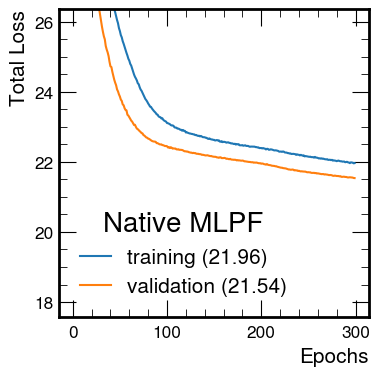

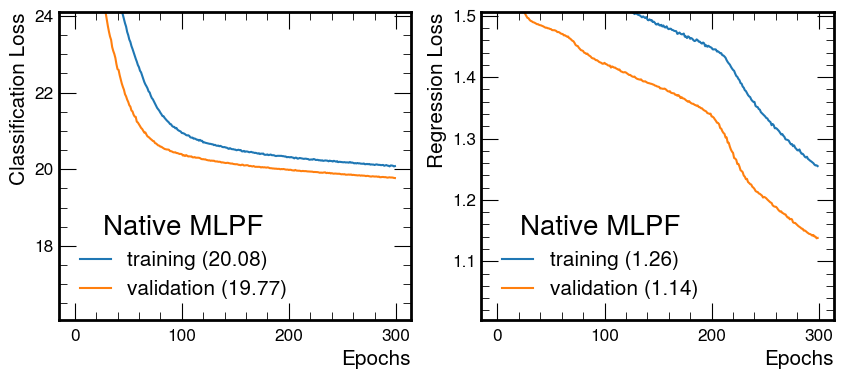

In [39]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(range(len(losses_train_tot)), losses_train_tot, label="training ({:.2f})".format(best_train_loss_tot))
ax.plot(range(len(losses_valid_tot)), losses_valid_tot, label="validation ({:.2f})".format(best_val_loss_tot))
ax.set_xlabel("Epochs")
ax.set_ylabel("Total Loss")
ax.set_ylim(0.8 * losses_train_tot[-1], 1.2 * losses_train_tot[-1])
if mode == "ssl":
    ax.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss id plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(range(len(losses_train_id)), losses_train_id, label="training ({:.2f})".format(best_train_loss_id))
ax1.plot(range(len(losses_valid_id)), losses_valid_id, label="validation ({:.2f})".format(best_val_loss_id))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Classification Loss")
ax1.set_ylim(0.8 * losses_train_id[-1], 1.2 * losses_train_id[-1])
if mode == "ssl":
    ax1.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax1.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss momentum plot
ax2.plot(
    range(len(losses_train_momentum)),
    losses_train_momentum,
    label="training ({:.2f})".format(best_train_loss_momentum),
)
ax2.plot(
    range(len(losses_valid_momentum)),
    losses_valid_momentum,
    label="validation ({:.2f})".format(best_val_loss_momentum),
)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Regression Loss")
ax2.set_ylim(0.8 * losses_train_momentum[-1], 1.2 * losses_train_momentum[-1])
if mode == "ssl":
    ax2.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax2.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)


losses_to_plot["native"]["tot"] = losses_valid_tot
losses_to_plot["native"]["id"] = losses_valid_id
losses_to_plot["native"]["p4"] = losses_valid_momentum    

In [17]:
with open(f"/pfclicvol/losses_to_plot.pkl", "wb") as f:  # dump model architecture
    pkl.dump(losses_to_plot, f, protocol=pkl.HIGHEST_PROTOCOL)

# Compare native vs ssl

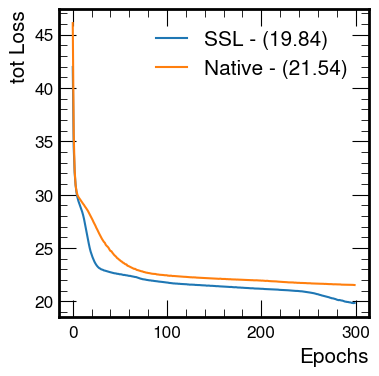

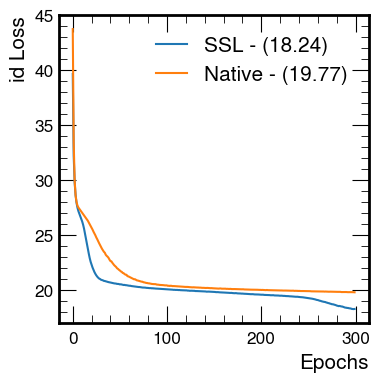

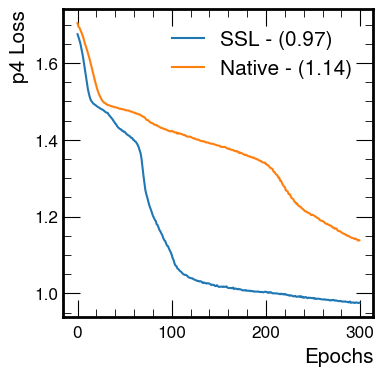

In [40]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

for loss in losses_to_plot["ssl"]:
    # make total loss plot
    fig, ax = plt.subplots(figsize=(4,4))
    ssl = np.array(losses_to_plot["ssl"][loss])
    native = np.array(losses_to_plot["native"][loss])
    ax.plot(range(len(ssl)), ssl, label=f"SSL - ({ssl.min():.2f})")
    ax.plot(range(len(native)), native, label=f"Native - ({native.min():.2f})")
    ax.set_xlabel("Epochs")
    ax.set_ylabel(f"{loss} Loss")
    ax.legend(loc="best", title_fontsize=20, fontsize=15)

In [41]:
print(f"num of parameters for native model is: {sum(p.numel() for p in mlpf.parameters() if p.requires_grad)}")

num of parameters for native model is: 1631501


In [42]:
print(f"num of parameters for ssl model is: {sum(p.numel() for p in mlpf.parameters() if p.requires_grad)}")

num of parameters for ssl model is: 1631501


In [43]:
outpath

'/pfclicvol/experiments/VICReg_2_1/'

In [49]:
if args.ssl:

    mlpf_model_kwargs = {
        "input_dim": input_,
        "embedding_dim": args.embedding_dim_mlpf,
        "width": args.width_mlpf,
        "k": args.nearest,
        "num_convs": args.num_convs_mlpf,
        "dropout": args.dropout_mlpf,
        "ssl": True,
        "VICReg_embedding_dim": args.embedding_dim_VICReg,
    }

    mlpf_ssl = MLPF(**mlpf_model_kwargs).to(device)
    print(mlpf_ssl)
    print(f"MLPF model name: {args.prefix_mlpf}_ssl")

    # make mlpf specific directory
    outpath_ssl = osp.join(f"{outpath}/MLPF/", f"{args.prefix_mlpf}_ssl")
    save_MLPF(args, outpath_ssl, mlpf_ssl, mlpf_model_kwargs, mode="ssl")

    print(f"- Training ssl based MLPF over {args.n_epochs_mlpf} epochs")

    training_loop_mlpf(
        device,
        vicreg_encoder,
        mlpf_ssl,
        train_loader,
        valid_loader,
        args.n_epochs_mlpf,
        args.patience,
        args.lr,
        outpath_ssl,
        mode="ssl",
    )

MLPF(
  (nn_id): Sequential(
    (0): Linear(in_features=272, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ELU(alpha=1.0)
    (10): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ELU(alpha=1.0)
    (14): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (15): Linear(in_features=256, out_features=6, bias=True)
  )
  (nn_pt): Sequential(
    (0): Linear(in_features=278, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout

AttributeError: 'objectview' object has no attribute 'data_split_mode'